# Mortality prediction performance

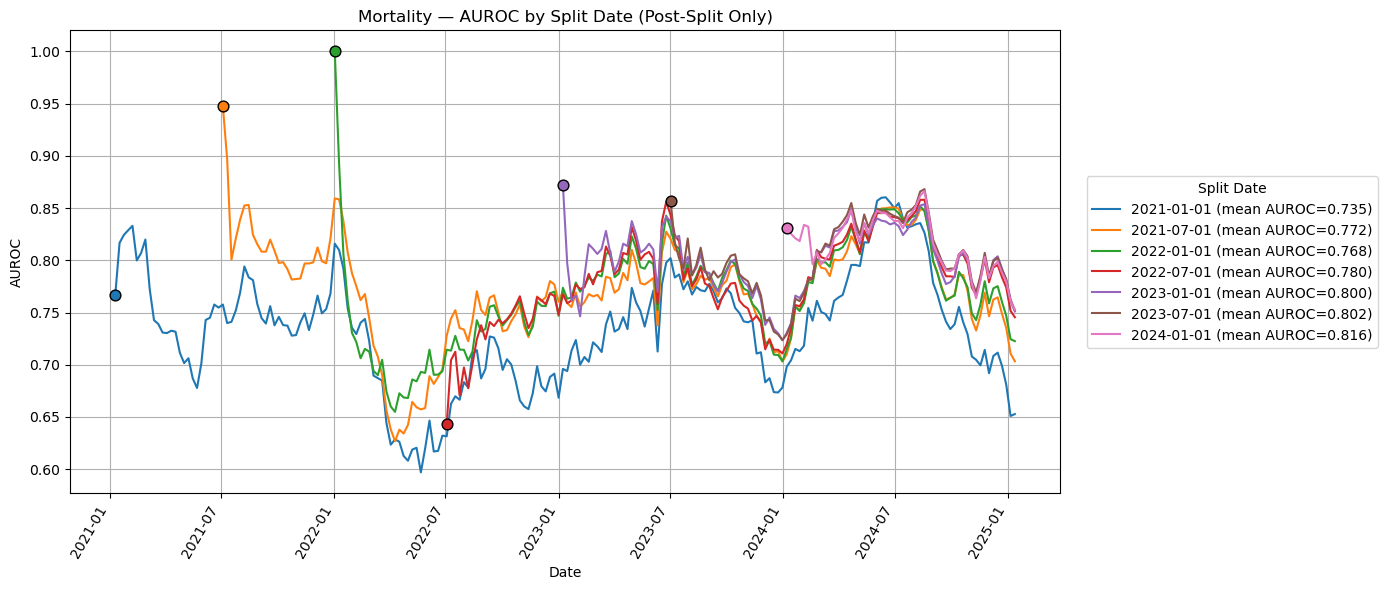

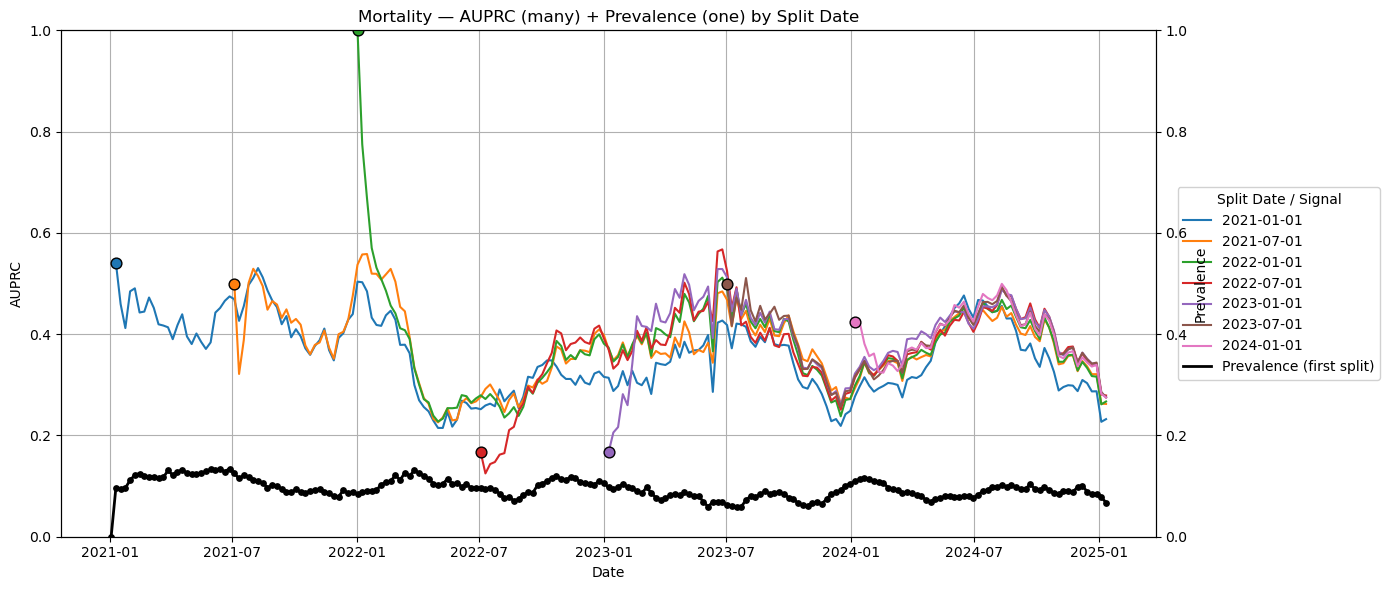

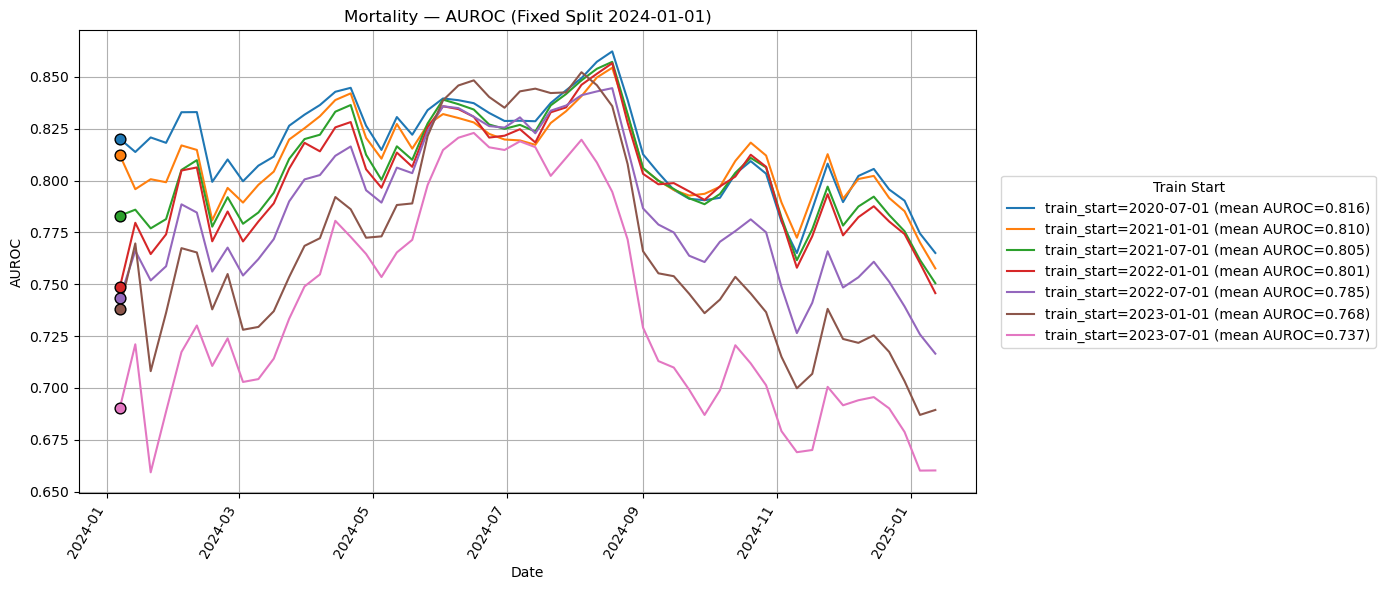

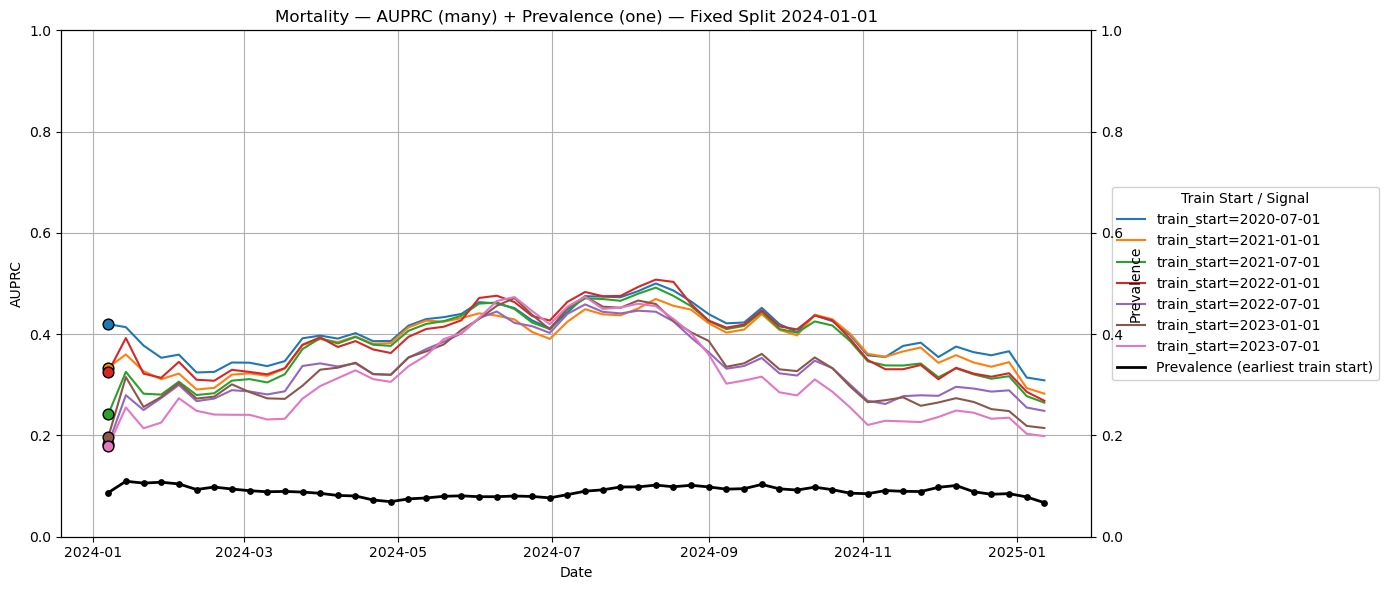

[DONE] Scaled AUPRC & prevalence to [0,1] and moved combined-plot legends outside.


In [6]:
# JUPYTER NOTEBOOK — Weekly-smoothed plots (AUROC; AUPRC+Prevalence combined)
# - AUPRC & Prevalence scaled to [0, 1] for display (clipped for safety)
# - Combined-plot legends placed outside to avoid overlapping lines

import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------
# Config (edit these)
# -------------------
RESULTS_DIR = "results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Choose the task you’re plotting: "mortality_", "los_", or "readmit30_"
TASK_PREFIX = "mortality_"

# Tag used in your fixed-split runs
FIXED_TAG = "fixedsplit_20240101"

# Optionally skip some split dates on the moving-split plots
SKIP_SPLIT_DATES = {"2024-07-01"}  # edit as needed

# Files with weekly-smoothed curves (saved by training scripts)
MOVING_CURVES = {
    "auroc": f"{TASK_PREFIX}auc_curves_results.csv",
    "auprc": f"{TASK_PREFIX}auprc_curves_results.csv",
    "prevalence": f"{TASK_PREFIX}prevalence_curves_results.csv",
}
FIXED_CURVES = {
    "auroc": f"{TASK_PREFIX}{FIXED_TAG}_auc_curves_results.csv",
    "auprc": f"{TASK_PREFIX}{FIXED_TAG}_auprc_curves_results.csv",
    "prevalence": f"{TASK_PREFIX}{FIXED_TAG}_prevalence_curves_results.csv",
}

def pretty_task_name(prefix: str) -> str:
    base = prefix.rstrip("_")
    return {
        "mortality": "Mortality",
        "los": "Length of Stay",
        "readmit30": "30-Day Readmission"
    }.get(base, base.title())

TASK_NAME = pretty_task_name(TASK_PREFIX)

# -------------------
# Helpers
# -------------------
def _exists(path):
    full = os.path.join(RESULTS_DIR, path)
    return full, os.path.exists(full)

def _fmt3(v):
    try:
        return f"{float(v):.3f}"
    except Exception:
        return "N/A"

def _post_split_only(df):
    """If a split_date column exists, keep post-split rows only."""
    if "split_date" in df.columns:
        try:
            s = pd.to_datetime(df["split_date"], errors="coerce")
            if s.nunique() == 1:
                split_dt = s.dropna().iloc[0]
                df = df[df["admitdatetime"] >= split_dt]
            else:
                df = df[df["admitdatetime"] >= s]
        except Exception:
            pass
    return df

def _clip01(series):
    """Clip to [0,1] for safe display."""
    return series.astype(float).clip(lower=0.0, upper=1.0)

# -------------------
# Strategy 1 (moving split dates)
# -------------------
def plot_moving_auroc_with_mean():
    path, ok = _exists(MOVING_CURVES["auroc"])
    if not ok:
        print(f"[WARN] Missing moving-split AUROC file: {path}")
        return

    df = pd.read_csv(path)
    df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
    df["split_date"] = df["split_date"].astype(str)
    df = _post_split_only(df)

    split_dates = sorted(d for d in df["split_date"].unique() if d not in SKIP_SPLIT_DATES)

    plt.figure(figsize=(14, 6))
    for sd in split_dates:
        sub = df[df["split_date"] == sd].copy()
        if sub.empty:
            continue
        mean_auroc = sub["auroc"].mean(skipna=True)
        label = f"{sd} (mean AUROC={_fmt3(mean_auroc)})"
        plt.plot(sub["admitdatetime"], sub["auroc"], linestyle='-', label=label)

        idx = sub["auroc"].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, "auroc"],
                        s=60, edgecolors="black", zorder=5)

    plt.xlabel("Date")
    plt.ylabel("AUROC")
    plt.title(f"{TASK_NAME} — AUROC by Split Date (Post-Split Only)")
    plt.xticks(rotation=60, ha="right")
    plt.grid(True)
    plt.legend(title="Split Date", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

def plot_moving_auprc_plus_prevalence():
    auprc_path, ok1 = _exists(MOVING_CURVES["auprc"])
    prev_path,  ok2 = _exists(MOVING_CURVES["prevalence"])
    if not (ok1 and ok2):
        print(f"[WARN] Missing moving-split AUPRC or Prevalence file:\n  {auprc_path}\n  {prev_path}")
        return

    au = pd.read_csv(auprc_path)
    pr = pd.read_csv(prev_path)

    for df in (au, pr):
        df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
        df["split_date"] = df["split_date"].astype(str)

    au = _post_split_only(au)
    pr = _post_split_only(pr)

    # Ensure metric columns are within [0,1] for display
    if "auprc" in au.columns:
        au["auprc"] = _clip01(au["auprc"])
    if "prevalence" in pr.columns:
        pr["prevalence"] = _clip01(pr["prevalence"])

    split_dates = sorted(d for d in au["split_date"].unique() if d not in SKIP_SPLIT_DATES)

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # AUPRC lines (multiple)
    for sd in split_dates:
        sub = au[au["split_date"] == sd].copy()
        if sub.empty:
            continue
        ax1.plot(sub["admitdatetime"], sub["auprc"], linestyle='-', label=f"{sd}")
        idx = sub["auprc"].first_valid_index()
        if idx is not None:
            ax1.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, "auprc"],
                        s=60, edgecolors="black", zorder=5)

    # Prevalence: ONLY from the FIRST split date
    if split_dates:
        first_sd = split_dates[0]
        prev_sub = pr[pr["split_date"] == first_sd].copy()
        if not prev_sub.empty:
            ax2.plot(prev_sub["admitdatetime"], prev_sub["prevalence"],
                     linestyle='-', color='black', linewidth=2.0, label="Prevalence (first split)")
            ax2.scatter(prev_sub["admitdatetime"], prev_sub["prevalence"],
                        s=15, color='black')

    # Scale both axes to 0–1
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("AUPRC")
    ax2.set_ylabel("Prevalence")
    ax1.set_title(f"{TASK_NAME} — AUPRC (many) + Prevalence (one) by Split Date")

    ax1.grid(True)

    # Legend OUTSIDE (right) to avoid overlap
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
               title="Split Date / Signal",
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               framealpha=0.9, borderaxespad=0.)
    fig.tight_layout()
    plt.show()

# -------------------
# Strategy 2 (fixed split; multiple train_start_date)
# -------------------
def plot_fixed_auroc_with_mean():
    path, ok = _exists(FIXED_CURVES["auroc"])
    if not ok:
        print(f"[WARN] Missing fixed-split AUROC file: {path}")
        return

    df = pd.read_csv(path)
    df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
    if "split_date" in df.columns:
        df["split_date"] = pd.to_datetime(df["split_date"], errors="coerce")
    if "train_start_date" in df.columns:
        df["train_start_date"] = pd.to_datetime(df["train_start_date"], errors="coerce")

    df = _post_split_only(df)

    plt.figure(figsize=(14, 6))
    train_starts = sorted(df["train_start_date"].dropna().unique()) if "train_start_date" in df.columns else []
    for ts in train_starts:
        sub = df[df["train_start_date"] == ts].copy()
        if sub.empty:
            continue
        mean_auroc = sub["auroc"].mean(skipna=True)
        ts_label = pd.to_datetime(ts).strftime("%Y-%m-%d")
        label = f"train_start={ts_label} (mean AUROC={_fmt3(mean_auroc)})"
        plt.plot(sub["admitdatetime"], sub["auroc"], linestyle='-', label=label)

        idx = sub["auroc"].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, "auroc"],
                        s=60, edgecolors="black", zorder=5)

    plt.xlabel("Date")
    plt.ylabel("AUROC")
    plt.title(f"{TASK_NAME} — AUROC (Fixed Split 2024-01-01)")
    plt.xticks(rotation=60, ha="right")
    plt.grid(True)
    plt.legend(title="Train Start", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

def plot_fixed_auprc_plus_prevalence():
    auprc_path, ok1 = _exists(FIXED_CURVES["auprc"])
    prev_path,  ok2 = _exists(FIXED_CURVES["prevalence"])
    if not (ok1 and ok2):
        print(f"[WARN] Missing fixed-split AUPRC or Prevalence file:\n  {auprc_path}\n  {prev_path}")
        return

    au = pd.read_csv(auprc_path)
    pr = pd.read_csv(prev_path)

    for df in (au, pr):
        df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
        if "split_date" in df.columns:
            df["split_date"] = pd.to_datetime(df["split_date"], errors="coerce")
        if "train_start_date" in df.columns:
            df["train_start_date"] = pd.to_datetime(df["train_start_date"], errors="coerce")

    au = _post_split_only(au)
    pr = _post_split_only(pr)

    # Clip to [0,1] for display
    if "auprc" in au.columns:
        au["auprc"] = _clip01(au["auprc"])
    if "prevalence" in pr.columns:
        pr["prevalence"] = _clip01(pr["prevalence"])

    train_starts = sorted(au["train_start_date"].dropna().unique()) if "train_start_date" in au.columns else []

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # AUPRC lines (multiple by train_start_date)
    for ts in train_starts:
        sub = au[au["train_start_date"] == ts].copy()
        if sub.empty:
            continue
        ts_label = pd.to_datetime(ts).strftime("%Y-%m-%d")
        ax1.plot(sub["admitdatetime"], sub["auprc"], linestyle='-', label=f"train_start={ts_label}")
        idx = sub["auprc"].first_valid_index()
        if idx is not None:
            ax1.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, "auprc"],
                        s=60, edgecolors="black", zorder=5)

    # Prevalence: ONLY from the EARLIEST train_start_date
    if train_starts:
        earliest_ts = train_starts[0]
        prev_sub = pr[pr["train_start_date"] == earliest_ts].copy()
        if not prev_sub.empty:
            ax2.plot(prev_sub["admitdatetime"], prev_sub["prevalence"],
                     linestyle='-', color='black', linewidth=2.0, label="Prevalence (earliest train start)")
            ax2.scatter(prev_sub["admitdatetime"], prev_sub["prevalence"],
                        s=15, color='black')

    # Scale both axes to 0–1
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("AUPRC")
    ax2.set_ylabel("Prevalence")
    ax1.set_title(f"{TASK_NAME} — AUPRC (many) + Prevalence (one) — Fixed Split 2024-01-01")

    ax1.grid(True)

    # Legend OUTSIDE (right) to avoid overlap
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
               title="Train Start / Signal",
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               framealpha=0.9, borderaxespad=0.)
    fig.tight_layout()
    plt.show()

# -------------
# Make all plots
# -------------
plot_moving_auroc_with_mean()          # Strategy 1: AUROC with mean in legend
plot_moving_auprc_plus_prevalence()    # Strategy 1: combined AUPRC + single prevalence (first split)

plot_fixed_auroc_with_mean()           # Strategy 2: AUROC with mean in legend
plot_fixed_auprc_plus_prevalence()     # Strategy 2: combined AUPRC + single prevalence (earliest train start)

print("[DONE] Scaled AUPRC & prevalence to [0,1] and moved combined-plot legends outside.")

# LOS Prediction performance

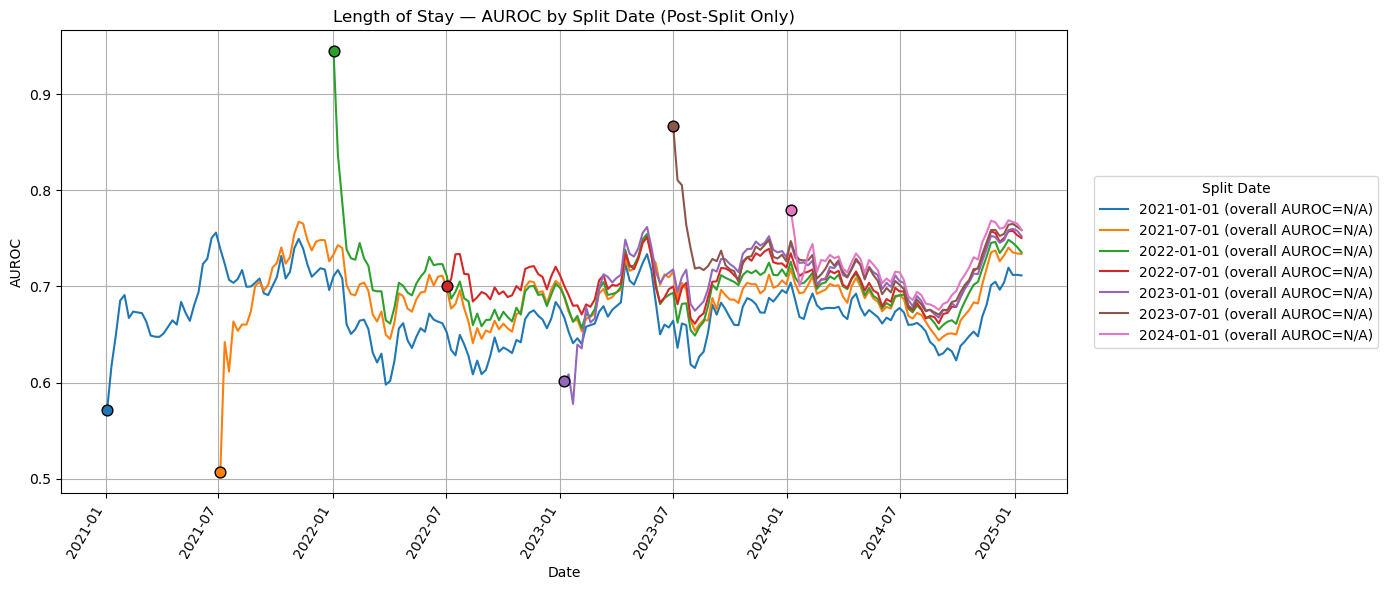

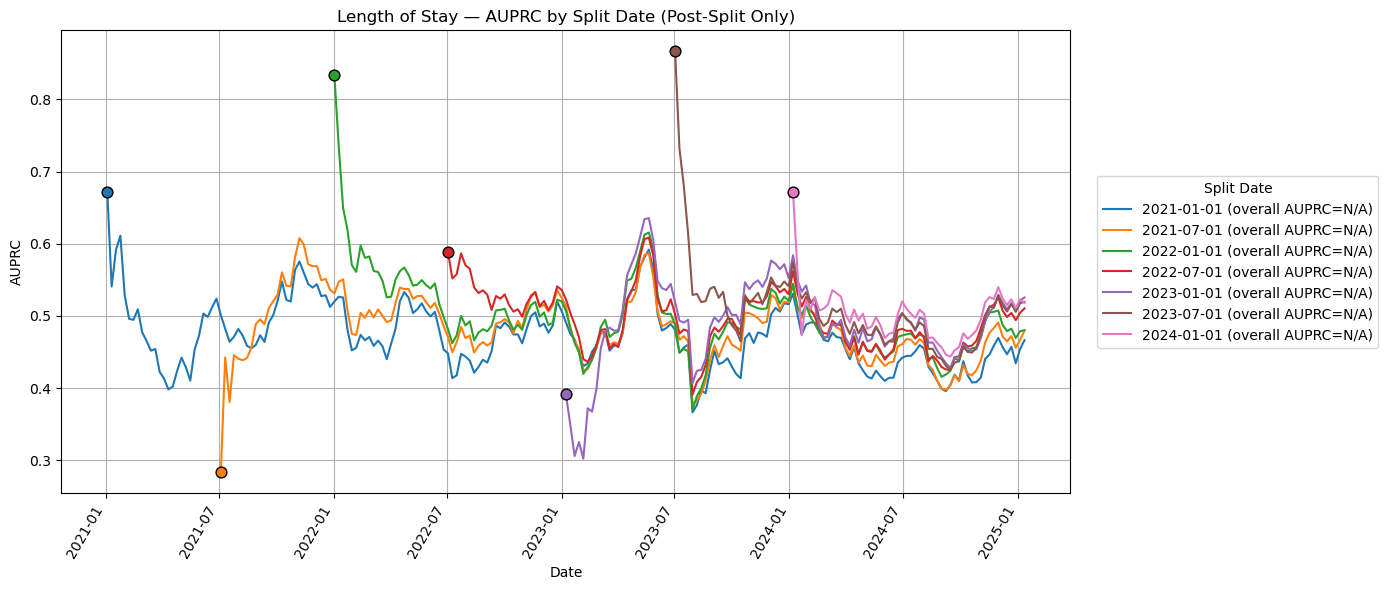

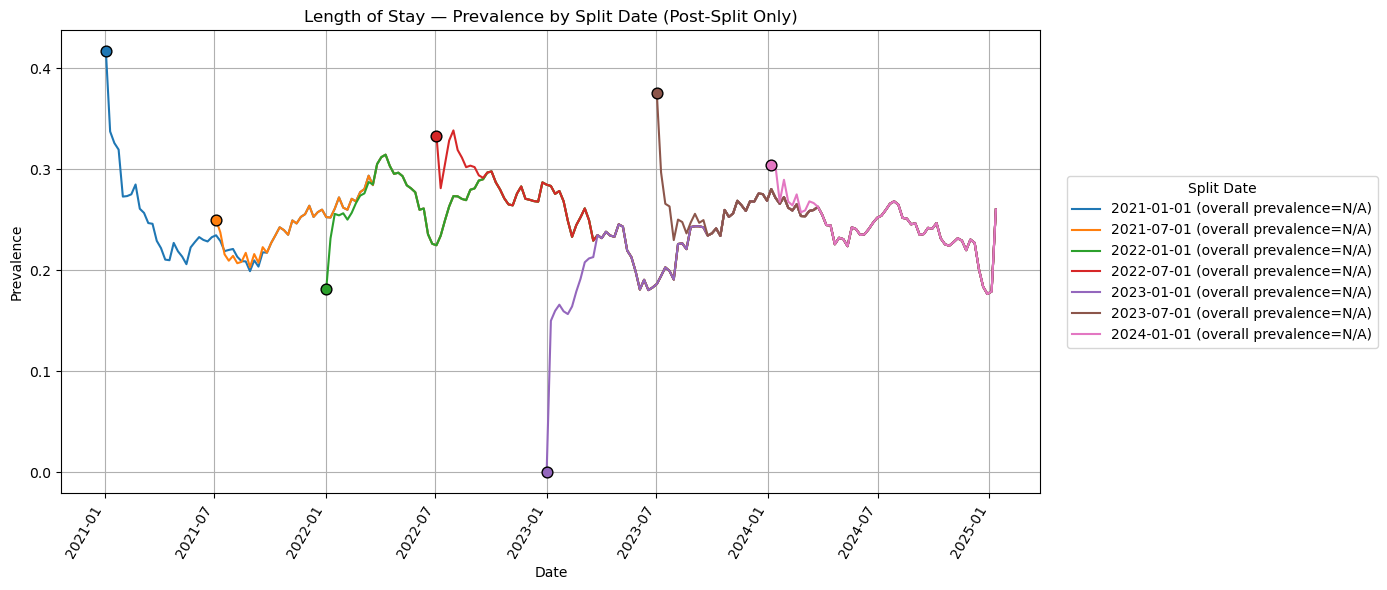

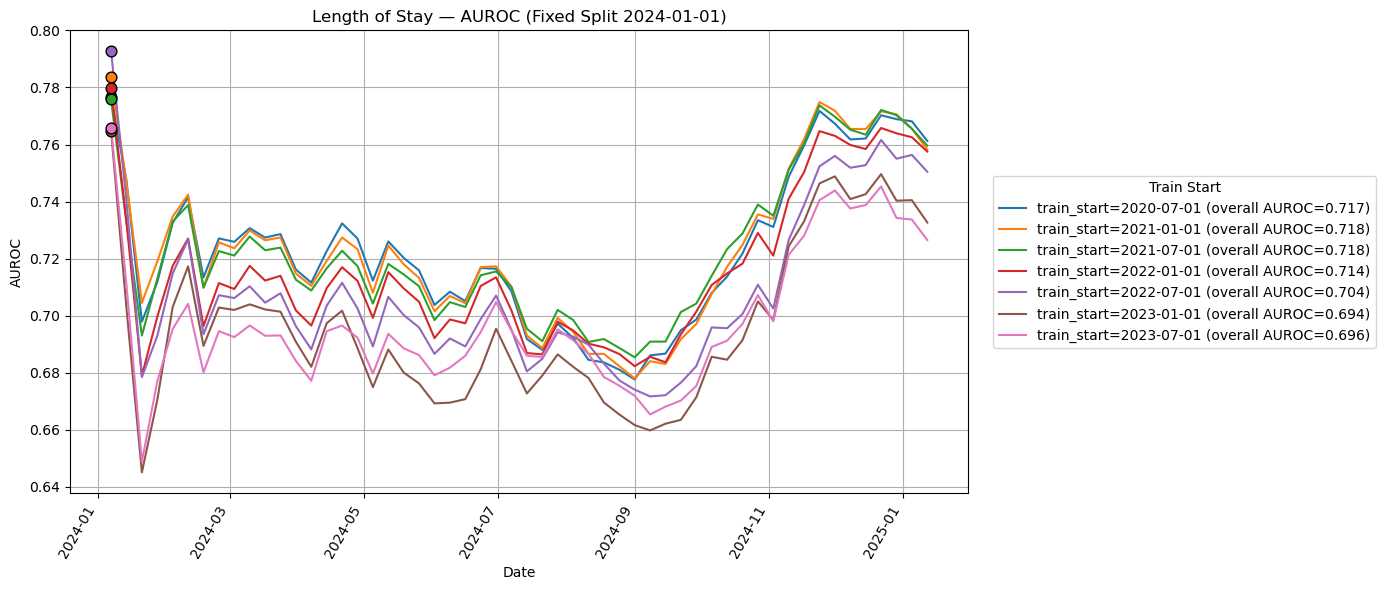

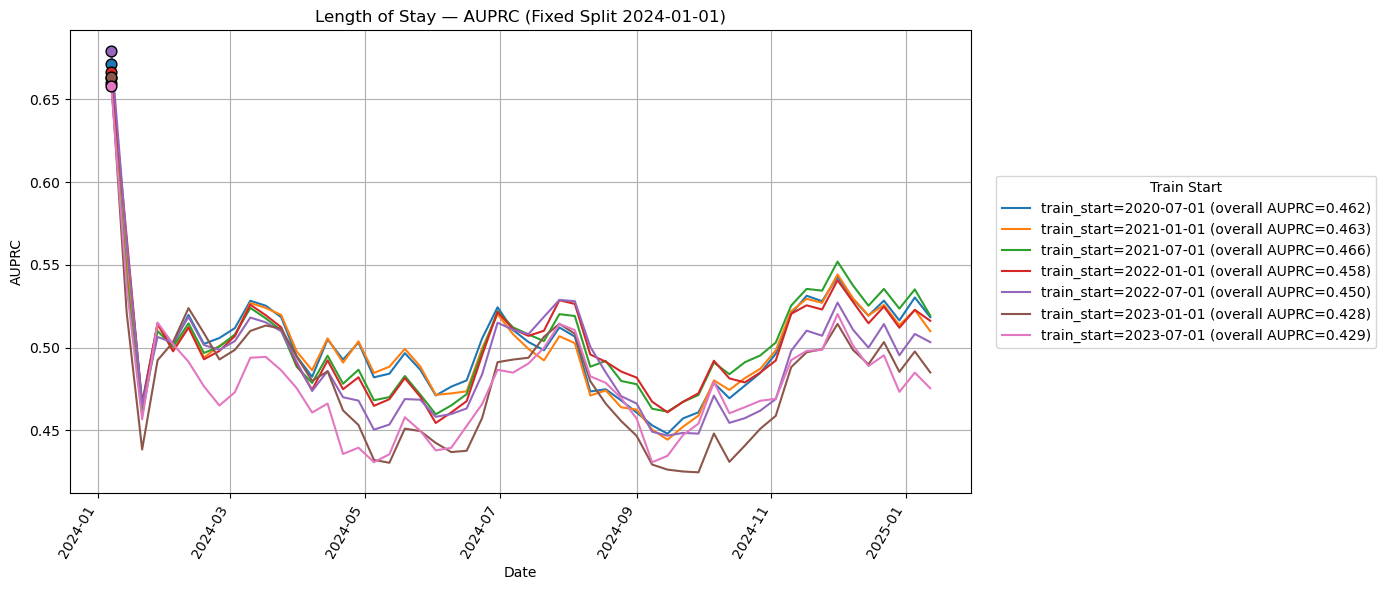

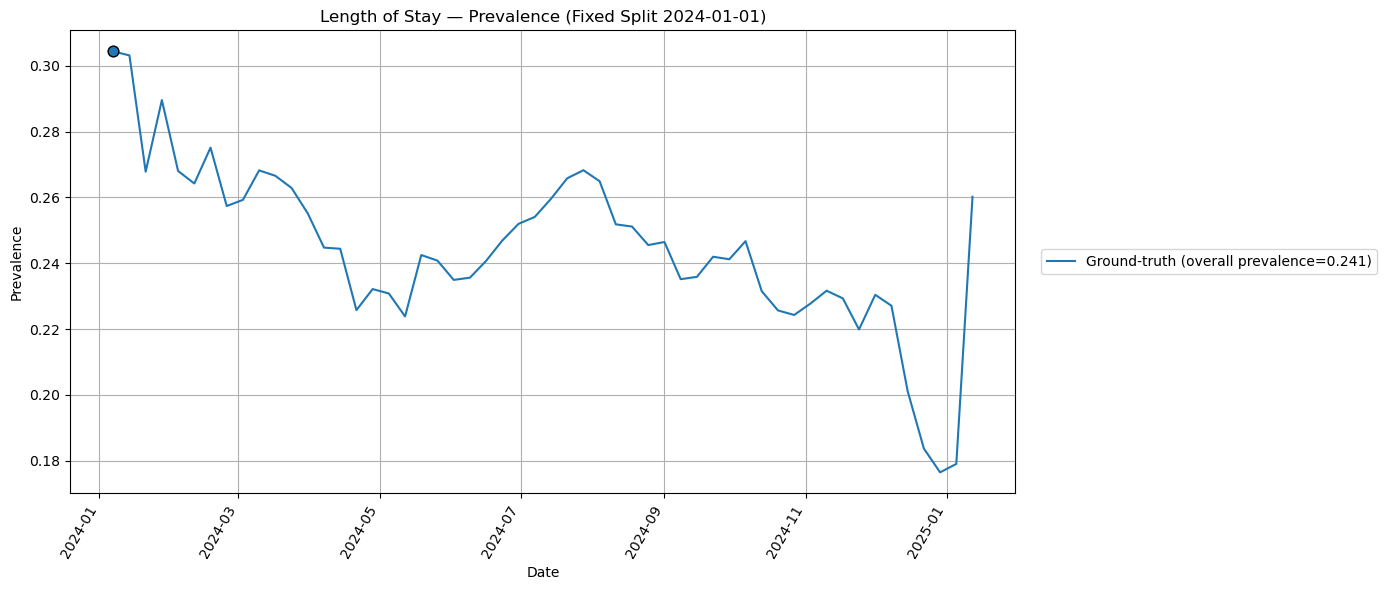

[DONE] Rendered weekly-smoothed plots with legends using OVERALL metrics; fixed-split shows a single prevalence line.


In [8]:
# JUPYTER NOTEBOOK — Weekly-smoothed plots (AUROC, AUPRC, Prevalence)
# Strategy 1: moving split dates
# Strategy 2: fixed split (2024-01-01) with rolling train starts
# Revisions:
#   • Legends show OVERALL metrics from scored_predictions (not weekly means)
#   • For fixed-split, plot ONLY ONE prevalence line (ground-truth) to avoid confusion
#   • Legend wording uses "overall AUROC", "overall AUPRC", "overall prevalence"

import os
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

# -------------------
# Config (edit these)
# -------------------
RESULTS_DIR = "results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Choose the task you’re plotting: "mortality_", "los_", or "readmit30_"
TASK_PREFIX = "los_"

# Tag used in your fixed-split runs
FIXED_TAG = "fixedsplit_20240101"

# Optionally skip some split dates on the moving-split plots
SKIP_SPLIT_DATES = {"2024-07-01"}  # edit as needed

# Files with weekly-smoothed curves (saved by training scripts)
MOVING_CURVES = {
    "auroc": f"{TASK_PREFIX}auc_curves_results.csv",
    "auprc": f"{TASK_PREFIX}auprc_curves_results.csv",
    "prevalence": f"{TASK_PREFIX}prevalence_curves_results.csv",
}
FIXED_CURVES = {
    "auroc": f"{TASK_PREFIX}{FIXED_TAG}_auc_curves_results.csv",
    "auprc": f"{TASK_PREFIX}{FIXED_TAG}_auprc_curves_results.csv",
    "prevalence": f"{TASK_PREFIX}{FIXED_TAG}_prevalence_curves_results.csv",
}

# Per-row predictions (to compute true OVERALL metrics for legends)
MOVING_SCORED = f"{TASK_PREFIX}scored_predictions.csv"
FIXED_SCORED  = f"{TASK_PREFIX}{FIXED_TAG}_scored_predictions.csv"

def pretty_task_name(prefix: str) -> str:
    base = prefix.rstrip("_")
    return {"mortality":"Mortality","los":"Length of Stay","readmit30":"30-Day Readmission"}.get(base, base.title())

TASK_NAME = pretty_task_name(TASK_PREFIX)

# -------------------------
# Overall metrics utilities
# -------------------------
def _fmt(v):
    return "N/A" if (pd.isna(v) or v is None) else f"{float(v):.3f}"

def overall_from_scored(scored_path: str, group_col: str):
    """
    Return dict: group_value -> {'auroc':..., 'auprc':..., 'prevalence':...}
    Computed on the full test set per run (NOT weekly averages).
    """
    d = {}
    path = os.path.join(RESULTS_DIR, scored_path)
    if not os.path.exists(path):
        print(f"[WARN] Missing scored file: {path}")
        return d

    s = pd.read_csv(path)
    if "y_true" not in s.columns or "y_pred" not in s.columns:
        print(f"[WARN] {path} missing y_true/y_pred")
        return d

    s["y_true"] = s["y_true"].astype(int)
    s["y_pred"] = s["y_pred"].astype(float)

    if group_col in s.columns:
        if group_col.endswith("date"):
            s[group_col] = pd.to_datetime(s[group_col], errors="coerce")
    else:
        s[group_col] = "all"

    for g, gdf in s.groupby(group_col, dropna=False):
        y = gdf["y_true"].values
        p = gdf["y_pred"].values
        auroc = roc_auc_score(y, p) if len(set(y)) > 1 else float("nan")
        auprc = average_precision_score(y, p) if len(set(y)) > 1 else float("nan")
        prev  = float(y.mean())
        d[g]  = {"auroc": auroc, "auprc": auprc, "prevalence": prev}
    return d

overall_moving = overall_from_scored(MOVING_SCORED, "split_date")
overall_fixed  = overall_from_scored(FIXED_SCORED,  "train_start_date")

# -------------------
# Plot helpers
# -------------------
def plot_moving_split(metric: str, csv_name: str):
    """Strategy 1: Different split dates on one plot (weekly-smoothed)."""
    path = os.path.join(RESULTS_DIR, csv_name)
    if not os.path.exists(path):
        print(f"[WARN] Missing moving-split file: {path}")
        return

    df = pd.read_csv(path)
    df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
    df["split_date"] = df["split_date"].astype(str)

    split_dates = sorted(d for d in df["split_date"].unique() if d not in SKIP_SPLIT_DATES)

    plt.figure(figsize=(14, 6))
    for sd in split_dates:
        sub = df[df["split_date"] == sd].copy()
        # Post-split only
        try:
            sd_dt = pd.to_datetime(sd)
            sub = sub[sub["admitdatetime"] >= sd_dt]
        except Exception:
            pass
        if sub.empty:
            continue

        # Legend shows OVERALL metric from scored_predictions
        ov = overall_moving.get(sd, {})
        ylab = {"auroc":"AUROC","auprc":"AUPRC","prevalence":"prevalence"}[metric]
        label = f"{sd} (overall {ylab}={_fmt(ov.get(metric))})"

        plt.plot(sub["admitdatetime"], sub[metric], linestyle="-", label=label)

        # Bold first point
        idx = sub[metric].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, metric], s=60, edgecolors="black", zorder=5)

    ylab_full = {"auroc":"AUROC","auprc":"AUPRC","prevalence":"Prevalence"}[metric]
    plt.xlabel("Date"); plt.ylabel(ylab_full)
    plt.title(f"{TASK_NAME} — {ylab_full} by Split Date (Post-Split Only)")
    plt.xticks(rotation=60, ha="right"); plt.grid(True)
    plt.legend(title="Split Date", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout(); plt.show()

def plot_fixed_split(metric: str, csv_name: str):
    """
    Strategy 2: Fixed split (2024-01-01). For AUROC/AUPRC we plot multiple lines
    by train_start_date with legends showing the OVERALL metric.
    For prevalence, plot ONLY ONE ground-truth line with overall prevalence.
    """
    path = os.path.join(RESULTS_DIR, csv_name)
    if not os.path.exists(path):
        print(f"[WARN] Missing fixed-split file: {path}")
        return

    df = pd.read_csv(path)
    df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
    if "split_date" in df.columns:
        df["split_date"] = pd.to_datetime(df["split_date"], errors="coerce")
        df = df[df["admitdatetime"] >= df["split_date"]]
    if "train_start_date" in df.columns:
        df["train_start_date"] = pd.to_datetime(df["train_start_date"], errors="coerce")

    ylab_full = {"auroc":"AUROC","auprc":"AUPRC","prevalence":"Prevalence"}[metric]
    plt.figure(figsize=(14, 6))

    if metric == "prevalence":
        # ONE ground-truth prevalence line (identical across runs)
        if "train_start_date" in df.columns and not df["train_start_date"].dropna().empty:
            first_ts = sorted(df["train_start_date"].dropna().unique())[0]
            sub = df[df["train_start_date"] == first_ts].copy()
        else:
            sub = df.copy()

        # Overall prevalence (same for all runs in fixed-split)
        if overall_fixed:
            any_key = next(iter(overall_fixed))
            overall_prev = overall_fixed[any_key]["prevalence"]
            label = f"Ground-truth (overall prevalence={_fmt(overall_prev)})"
        else:
            label = "Ground-truth prevalence"

        plt.plot(sub["admitdatetime"], sub["prevalence"], linestyle="-", label=label)
        idx = sub["prevalence"].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, "prevalence"], s=60, edgecolors="black", zorder=5)

        plt.xlabel("Date"); plt.ylabel(ylab_full)
        plt.title(f"{TASK_NAME} — {ylab_full} (Fixed Split 2024-01-01)")
        plt.xticks(rotation=60, ha="right"); plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
        plt.tight_layout(); plt.show()
        return

    # AUROC/AUPRC: multiple lines with OVERALL metric per train_start_date
    train_starts = sorted(df["train_start_date"].dropna().unique()) if "train_start_date" in df.columns else []
    for ts in train_starts:
        sub = df[df["train_start_date"] == ts].copy()
        if sub.empty:
            continue
        ov = overall_fixed.get(ts, {})
        ts_label = pd.to_datetime(ts).strftime("%Y-%m-%d")
        # Legend shows the corresponding OVERALL metric name
        label = f"train_start={ts_label} (overall {ylab_full}={_fmt(ov.get(metric))})"

        plt.plot(sub["admitdatetime"], sub[metric], linestyle="-", label=label)
        idx = sub[metric].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, metric], s=60, edgecolors="black", zorder=5)

    plt.xlabel("Date"); plt.ylabel(ylab_full)
    plt.title(f"{TASK_NAME} — {ylab_full} (Fixed Split 2024-01-01)")
    plt.xticks(rotation=60, ha="right"); plt.grid(True)
    plt.legend(title="Train Start", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout(); plt.show()

# -------------
# Make all plots
# -------------
for metric, fname in MOVING_CURVES.items():
    plot_moving_split(metric, fname)

for metric, fname in FIXED_CURVES.items():
    plot_fixed_split(metric, fname)

print("[DONE] Rendered weekly-smoothed plots with legends using OVERALL metrics; fixed-split shows a single prevalence line.")





# 30 day readmission prediction performance

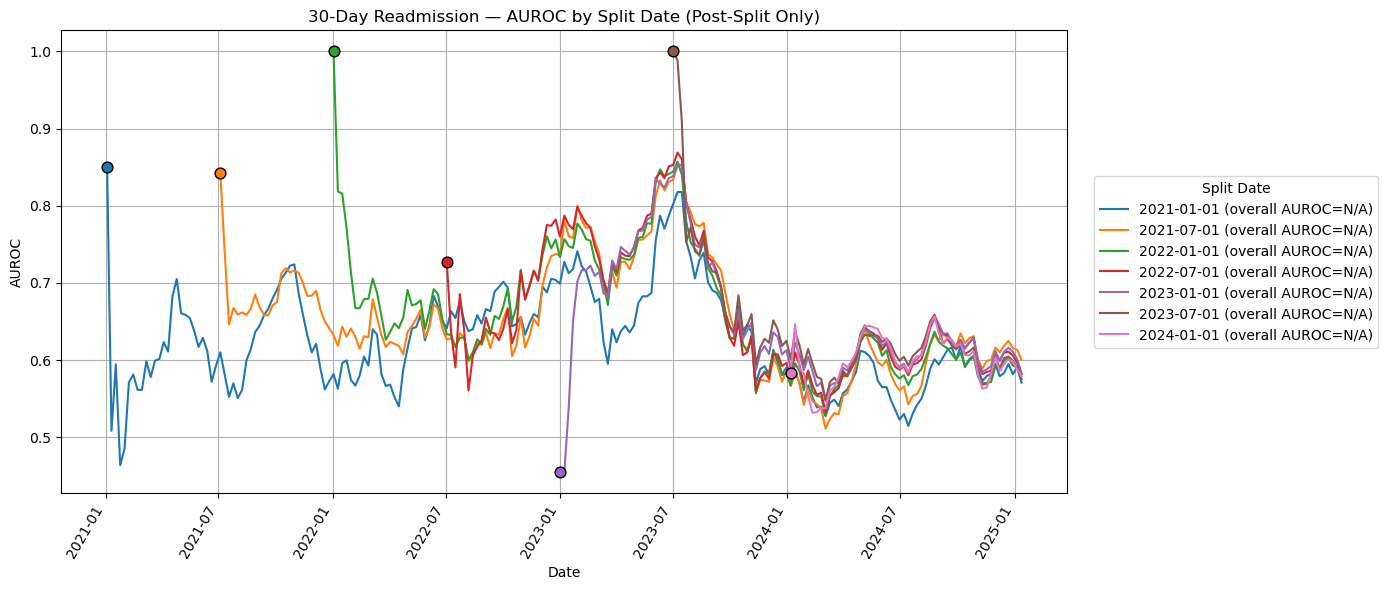

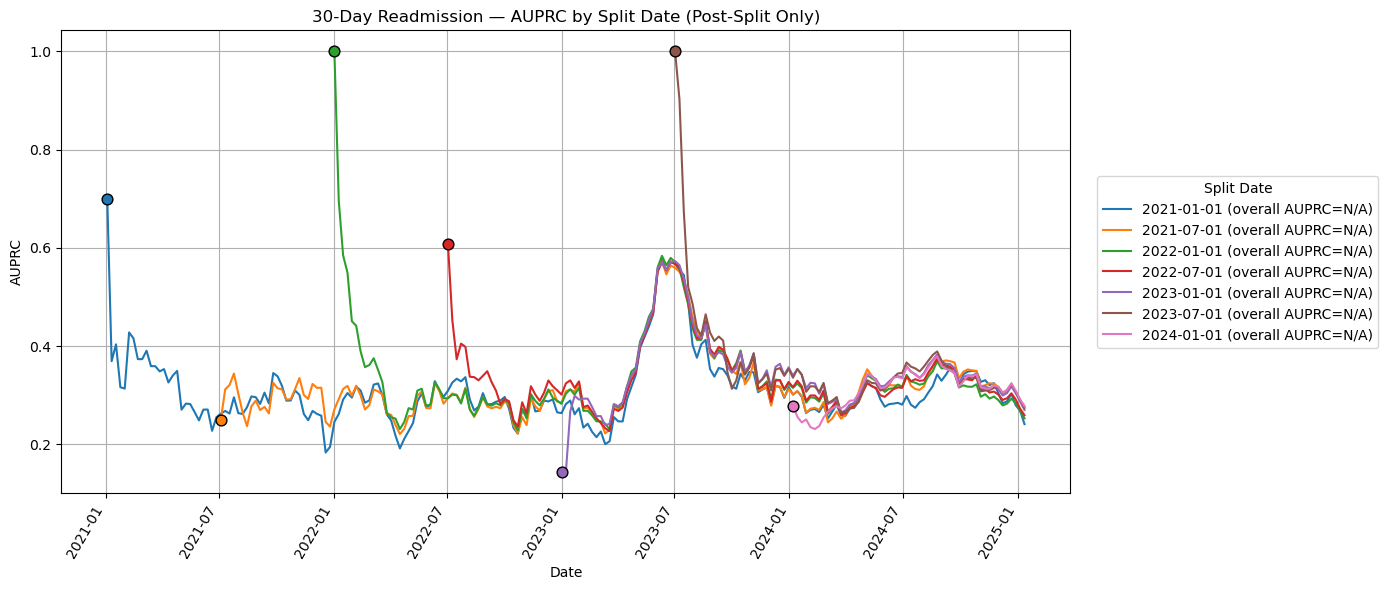

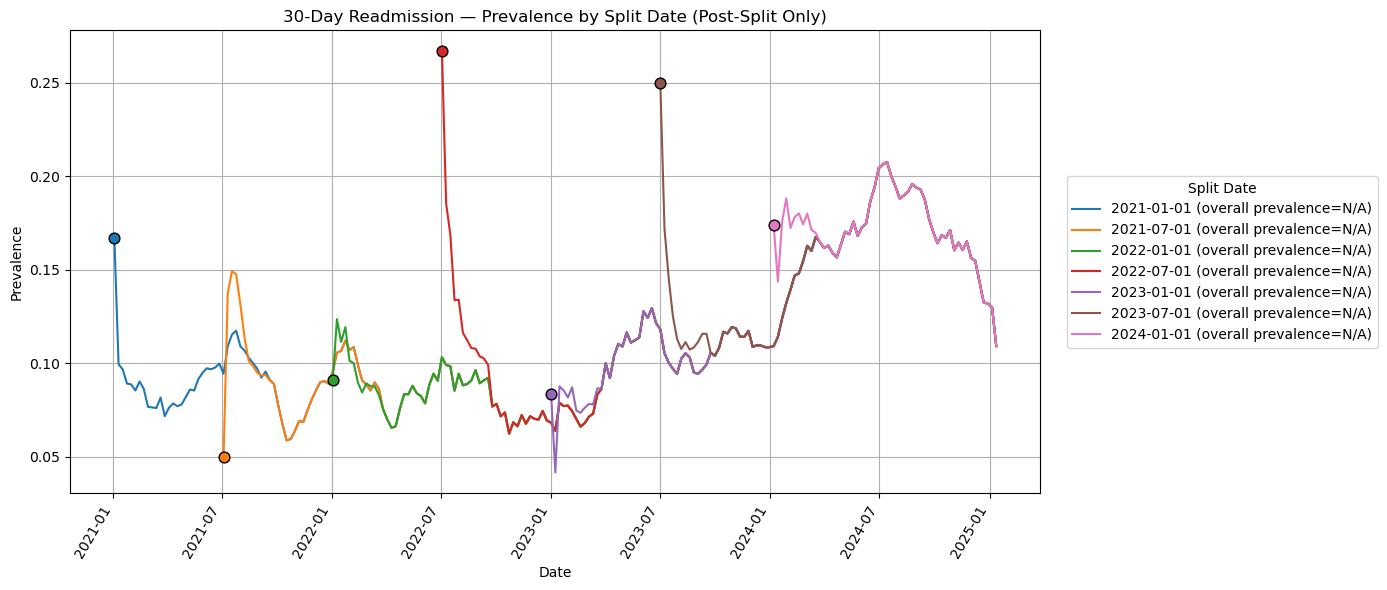

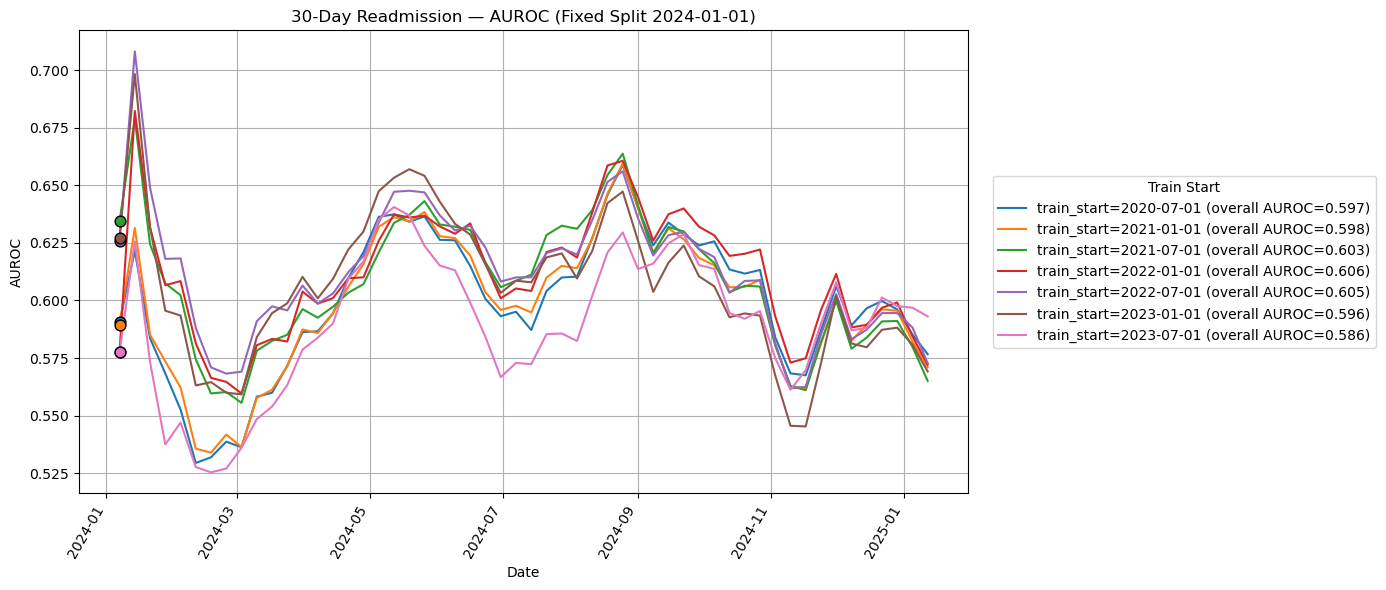

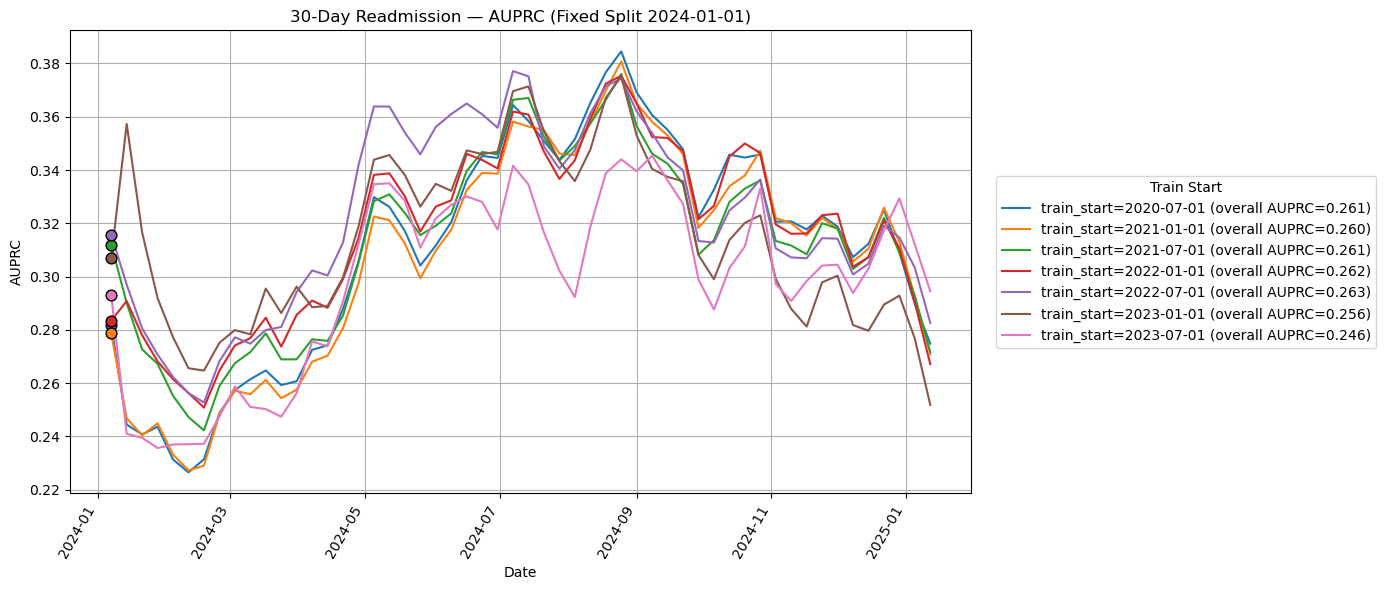

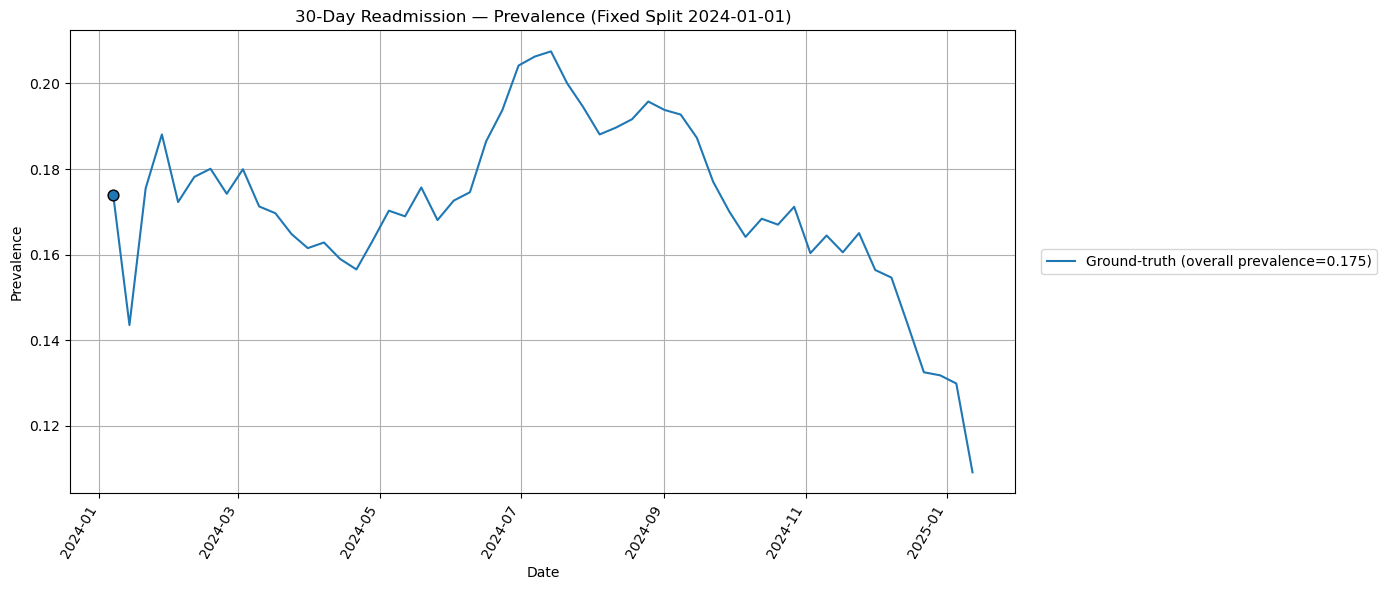

[DONE] Rendered weekly-smoothed plots with legends using OVERALL metrics; fixed-split shows a single prevalence line.


In [9]:
# JUPYTER NOTEBOOK — Weekly-smoothed plots (AUROC, AUPRC, Prevalence)
# Strategy 1: moving split dates
# Strategy 2: fixed split (2024-01-01) with rolling train starts
# Revisions:
#   • Legends show OVERALL metrics from scored_predictions (not weekly means)
#   • For fixed-split, plot ONLY ONE prevalence line (ground-truth) to avoid confusion
#   • Legend wording uses "overall AUROC", "overall AUPRC", "overall prevalence"

import os
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

# -------------------
# Config (edit these)
# -------------------
RESULTS_DIR = "results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Choose the task you’re plotting: "mortality_", "los_", or "readmit30_"
TASK_PREFIX = "readmit30_"

# Tag used in your fixed-split runs
FIXED_TAG = "fixedsplit_20240101"

# Optionally skip some split dates on the moving-split plots
SKIP_SPLIT_DATES = {"2024-07-01"}  # edit as needed

# Files with weekly-smoothed curves (saved by training scripts)
MOVING_CURVES = {
    "auroc": f"{TASK_PREFIX}auc_curves_results.csv",
    "auprc": f"{TASK_PREFIX}auprc_curves_results.csv",
    "prevalence": f"{TASK_PREFIX}prevalence_curves_results.csv",
}
FIXED_CURVES = {
    "auroc": f"{TASK_PREFIX}{FIXED_TAG}_auc_curves_results.csv",
    "auprc": f"{TASK_PREFIX}{FIXED_TAG}_auprc_curves_results.csv",
    "prevalence": f"{TASK_PREFIX}{FIXED_TAG}_prevalence_curves_results.csv",
}

# Per-row predictions (to compute true OVERALL metrics for legends)
MOVING_SCORED = f"{TASK_PREFIX}scored_predictions.csv"
FIXED_SCORED  = f"{TASK_PREFIX}{FIXED_TAG}_scored_predictions.csv"

def pretty_task_name(prefix: str) -> str:
    base = prefix.rstrip("_")
    return {"mortality":"Mortality","los":"Length of Stay","readmit30":"30-Day Readmission"}.get(base, base.title())

TASK_NAME = pretty_task_name(TASK_PREFIX)

# -------------------------
# Overall metrics utilities
# -------------------------
def _fmt(v):
    return "N/A" if (pd.isna(v) or v is None) else f"{float(v):.3f}"

def overall_from_scored(scored_path: str, group_col: str):
    """
    Return dict: group_value -> {'auroc':..., 'auprc':..., 'prevalence':...}
    Computed on the full test set per run (NOT weekly averages).
    """
    d = {}
    path = os.path.join(RESULTS_DIR, scored_path)
    if not os.path.exists(path):
        print(f"[WARN] Missing scored file: {path}")
        return d

    s = pd.read_csv(path)
    if "y_true" not in s.columns or "y_pred" not in s.columns:
        print(f"[WARN] {path} missing y_true/y_pred")
        return d

    s["y_true"] = s["y_true"].astype(int)
    s["y_pred"] = s["y_pred"].astype(float)

    if group_col in s.columns:
        if group_col.endswith("date"):
            s[group_col] = pd.to_datetime(s[group_col], errors="coerce")
    else:
        s[group_col] = "all"

    for g, gdf in s.groupby(group_col, dropna=False):
        y = gdf["y_true"].values
        p = gdf["y_pred"].values
        auroc = roc_auc_score(y, p) if len(set(y)) > 1 else float("nan")
        auprc = average_precision_score(y, p) if len(set(y)) > 1 else float("nan")
        prev  = float(y.mean())
        d[g]  = {"auroc": auroc, "auprc": auprc, "prevalence": prev}
    return d

overall_moving = overall_from_scored(MOVING_SCORED, "split_date")
overall_fixed  = overall_from_scored(FIXED_SCORED,  "train_start_date")

# -------------------
# Plot helpers
# -------------------
def plot_moving_split(metric: str, csv_name: str):
    """Strategy 1: Different split dates on one plot (weekly-smoothed)."""
    path = os.path.join(RESULTS_DIR, csv_name)
    if not os.path.exists(path):
        print(f"[WARN] Missing moving-split file: {path}")
        return

    df = pd.read_csv(path)
    df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
    df["split_date"] = df["split_date"].astype(str)

    split_dates = sorted(d for d in df["split_date"].unique() if d not in SKIP_SPLIT_DATES)

    plt.figure(figsize=(14, 6))
    for sd in split_dates:
        sub = df[df["split_date"] == sd].copy()
        # Post-split only
        try:
            sd_dt = pd.to_datetime(sd)
            sub = sub[sub["admitdatetime"] >= sd_dt]
        except Exception:
            pass
        if sub.empty:
            continue

        # Legend shows OVERALL metric from scored_predictions
        ov = overall_moving.get(sd, {})
        ylab = {"auroc":"AUROC","auprc":"AUPRC","prevalence":"prevalence"}[metric]
        label = f"{sd} (overall {ylab}={_fmt(ov.get(metric))})"

        plt.plot(sub["admitdatetime"], sub[metric], linestyle="-", label=label)

        # Bold first point
        idx = sub[metric].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, metric], s=60, edgecolors="black", zorder=5)

    ylab_full = {"auroc":"AUROC","auprc":"AUPRC","prevalence":"Prevalence"}[metric]
    plt.xlabel("Date"); plt.ylabel(ylab_full)
    plt.title(f"{TASK_NAME} — {ylab_full} by Split Date (Post-Split Only)")
    plt.xticks(rotation=60, ha="right"); plt.grid(True)
    plt.legend(title="Split Date", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout(); plt.show()

def plot_fixed_split(metric: str, csv_name: str):
    """
    Strategy 2: Fixed split (2024-01-01). For AUROC/AUPRC we plot multiple lines
    by train_start_date with legends showing the OVERALL metric.
    For prevalence, plot ONLY ONE ground-truth line with overall prevalence.
    """
    path = os.path.join(RESULTS_DIR, csv_name)
    if not os.path.exists(path):
        print(f"[WARN] Missing fixed-split file: {path}")
        return

    df = pd.read_csv(path)
    df["admitdatetime"] = pd.to_datetime(df["admitdatetime"], errors="coerce")
    if "split_date" in df.columns:
        df["split_date"] = pd.to_datetime(df["split_date"], errors="coerce")
        df = df[df["admitdatetime"] >= df["split_date"]]
    if "train_start_date" in df.columns:
        df["train_start_date"] = pd.to_datetime(df["train_start_date"], errors="coerce")

    ylab_full = {"auroc":"AUROC","auprc":"AUPRC","prevalence":"Prevalence"}[metric]
    plt.figure(figsize=(14, 6))

    if metric == "prevalence":
        # ONE ground-truth prevalence line (identical across runs)
        if "train_start_date" in df.columns and not df["train_start_date"].dropna().empty:
            first_ts = sorted(df["train_start_date"].dropna().unique())[0]
            sub = df[df["train_start_date"] == first_ts].copy()
        else:
            sub = df.copy()

        # Overall prevalence (same for all runs in fixed-split)
        if overall_fixed:
            any_key = next(iter(overall_fixed))
            overall_prev = overall_fixed[any_key]["prevalence"]
            label = f"Ground-truth (overall prevalence={_fmt(overall_prev)})"
        else:
            label = "Ground-truth prevalence"

        plt.plot(sub["admitdatetime"], sub["prevalence"], linestyle="-", label=label)
        idx = sub["prevalence"].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, "prevalence"], s=60, edgecolors="black", zorder=5)

        plt.xlabel("Date"); plt.ylabel(ylab_full)
        plt.title(f"{TASK_NAME} — {ylab_full} (Fixed Split 2024-01-01)")
        plt.xticks(rotation=60, ha="right"); plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
        plt.tight_layout(); plt.show()
        return

    # AUROC/AUPRC: multiple lines with OVERALL metric per train_start_date
    train_starts = sorted(df["train_start_date"].dropna().unique()) if "train_start_date" in df.columns else []
    for ts in train_starts:
        sub = df[df["train_start_date"] == ts].copy()
        if sub.empty:
            continue
        ov = overall_fixed.get(ts, {})
        ts_label = pd.to_datetime(ts).strftime("%Y-%m-%d")
        # Legend shows the corresponding OVERALL metric name
        label = f"train_start={ts_label} (overall {ylab_full}={_fmt(ov.get(metric))})"

        plt.plot(sub["admitdatetime"], sub[metric], linestyle="-", label=label)
        idx = sub[metric].first_valid_index()
        if idx is not None:
            plt.scatter(sub.loc[idx, "admitdatetime"], sub.loc[idx, metric], s=60, edgecolors="black", zorder=5)

    plt.xlabel("Date"); plt.ylabel(ylab_full)
    plt.title(f"{TASK_NAME} — {ylab_full} (Fixed Split 2024-01-01)")
    plt.xticks(rotation=60, ha="right"); plt.grid(True)
    plt.legend(title="Train Start", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout(); plt.show()

# -------------
# Make all plots
# -------------
for metric, fname in MOVING_CURVES.items():
    plot_moving_split(metric, fname)

for metric, fname in FIXED_CURVES.items():
    plot_fixed_split(metric, fname)

print("[DONE] Rendered weekly-smoothed plots with legends using OVERALL metrics; fixed-split shows a single prevalence line.")





## Data Drift Metrics Overview - Intake Data Only

This notebook evaluates multiple types of drift metrics in relation to model prediction performance (AUROC) over time. Below are the definitions of each drift metric:

### 🔹 Outlier Ratio (Isolation Forest)
- **What it measures:** Proportion of samples flagged as outliers based on all structured + text features.
- **Method:** Isolation Forest using a baseline window pre-split.
- **Interpretation:** High outlier ratio indicates distribution shift in the feature space.

### 🔹 Data Drift Metrics (Per-Feature)
1. **Numeric Drift (KS Statistic)**
   - Measures: Kolmogorov–Smirnov statistic between baseline and target distribution for numeric features.
   - Range: 0 to 1 (higher = greater shift).
2. **Categorical Drift (Chi-Square p-value)**
   - Measures: Statistical significance of distributional change in categorical features.
   - Range: 0 to 1 (lower = more significant change).
3. **Text Drift (Jensen-Shannon Divergence)**
   - Measures: Shift in word usage and note structure in text fields.
   - Range: 0 to 1 (higher = greater divergence).

### 🔹 Feature Drift via PCA
- **What it measures:** Multivariate shift in the full feature space (numeric + categorical + text).
- **Method:** PCA projection of feature space, comparing post-split rolling windows to a fixed 3-month baseline.
- **Two Metrics:**
  1. **Avg PCA KS** – Drift in each principal component (distributional shift).
  2. **Avg PCA JS** – Divergence in principal component histograms (distributional dissimilarity).

### 🔹 AUROC (Prediction Performance)
- **What it measures:** Model discrimination ability for each rolling prediction window.
- **Interpretation:** Decreases in AUROC may indicate reduced generalization due to data drift.

---

These metrics are used to monitor the stability of input features and assess their correlation with model performance changes over time.




# Outlier drift

In [10]:
# -----------------------
# Drift Plot only (with start dot + skip last split + legend on side)
# -----------------------
plt.figure(figsize=(14, 6))

# Filter split_dates to skip 2024-07-01
filtered_split_dates = [d for d in split_dates if str(d) != "2024-07-01"]

for i, split_date in enumerate(filtered_split_dates):
    color = colors(i)
    
    # Subset data for split
    drift_subset = drift_df[(drift_df['split_date'] == split_date) & 
                            (drift_df[date_col_drift] >= pd.to_datetime(split_date))]
    
    # Plot line
    plt.plot(drift_subset[date_col_drift], drift_subset[drift_col], linestyle='-', color=color, 
             label=f"{split_date}")
    
    # Add dot at first non-NaN point
    first_valid_idx = drift_subset[drift_col].first_valid_index()
    if first_valid_idx is not None:
        plt.scatter(drift_subset.loc[first_valid_idx, date_col_drift], 
                    drift_subset.loc[first_valid_idx, drift_col], 
                    color=color, edgecolors='black', zorder=5)

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Outlier Ratio")
plt.title("Drift Outlier Ratio by Split Date (Post-Split Only)")
plt.xticks(rotation=60, ha='right')

# Legend moved to side
plt.legend(title="Split Date", loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'split_dates' is not defined

<Figure size 1400x600 with 0 Axes>

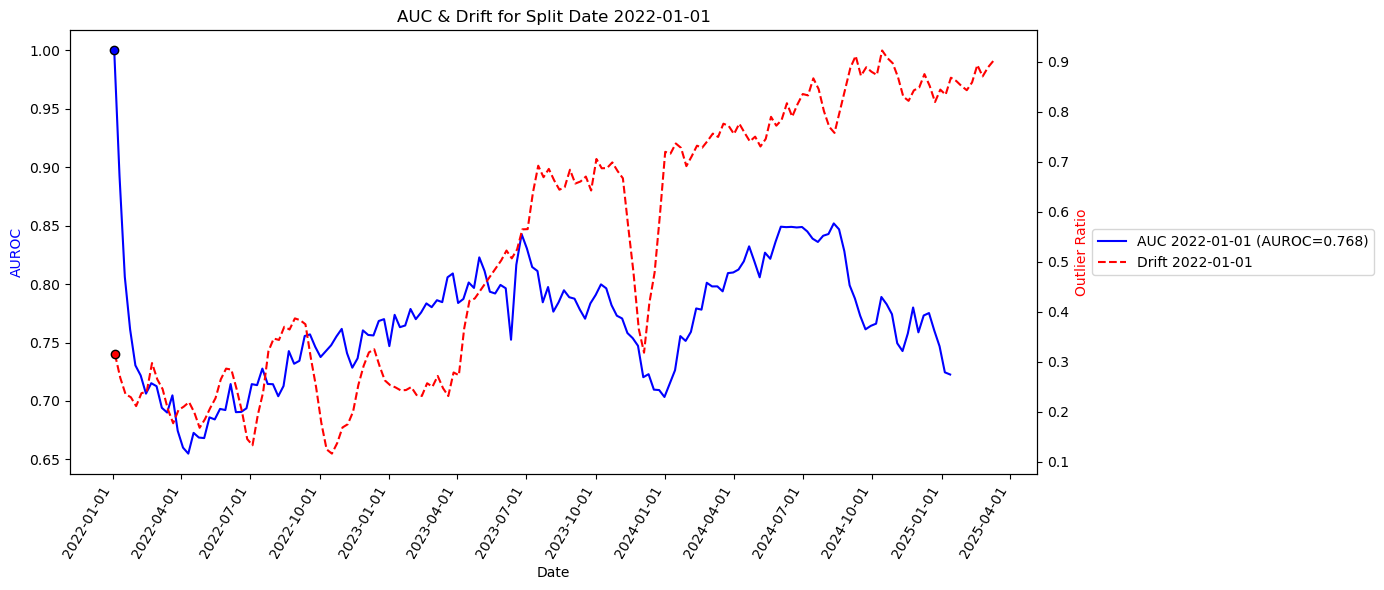

In [8]:
target_split = "2022-01-01"

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

color_auc = "blue"
color_drift = "red"

# --- AUC (solid) ---
auc_subset = auc_df[(auc_df['split_date'] == target_split) & 
                    (pd.to_datetime(auc_df['admitdatetime']) >= pd.to_datetime(target_split))]
overall_auc = auc_df.loc[auc_df['split_date'] == target_split, 'auroc'].mean()
ax1.plot(pd.to_datetime(auc_subset['admitdatetime']), auc_subset['auroc'], 
         linestyle='-', color=color_auc, label=f"AUC {target_split} (AUROC={overall_auc:.3f})")
first_valid_auc = auc_subset['auroc'].first_valid_index()
if first_valid_auc is not None:
    ax1.scatter(pd.to_datetime(auc_subset.loc[first_valid_auc, 'admitdatetime']), 
                auc_subset.loc[first_valid_auc, 'auroc'], 
                color=color_auc, edgecolors='black', zorder=5)

# --- Drift (dashed) ---
drift_subset = drift_df[(drift_df['split_date'] == target_split) & 
                        (pd.to_datetime(drift_df['start_week']) >= pd.to_datetime(target_split))]
ax2.plot(pd.to_datetime(drift_subset['start_week']), drift_subset['4wk_avg_ratio'], 
         linestyle='--', color=color_drift, label=f"Drift {target_split}")
first_valid_drift = drift_subset['4wk_avg_ratio'].first_valid_index()
if first_valid_drift is not None:
    ax2.scatter(pd.to_datetime(drift_subset.loc[first_valid_drift, 'start_week']), 
                drift_subset.loc[first_valid_drift, '4wk_avg_ratio'], 
                color=color_drift, edgecolors='black', zorder=5)

# Formatting
ax1.set_xlabel("Date")
ax1.set_ylabel("AUROC", color=color_auc)
ax2.set_ylabel("Outlier Ratio", color=color_drift)

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=60, ha='right')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.title(f"AUC & Drift for Split Date {target_split}")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# Data drift

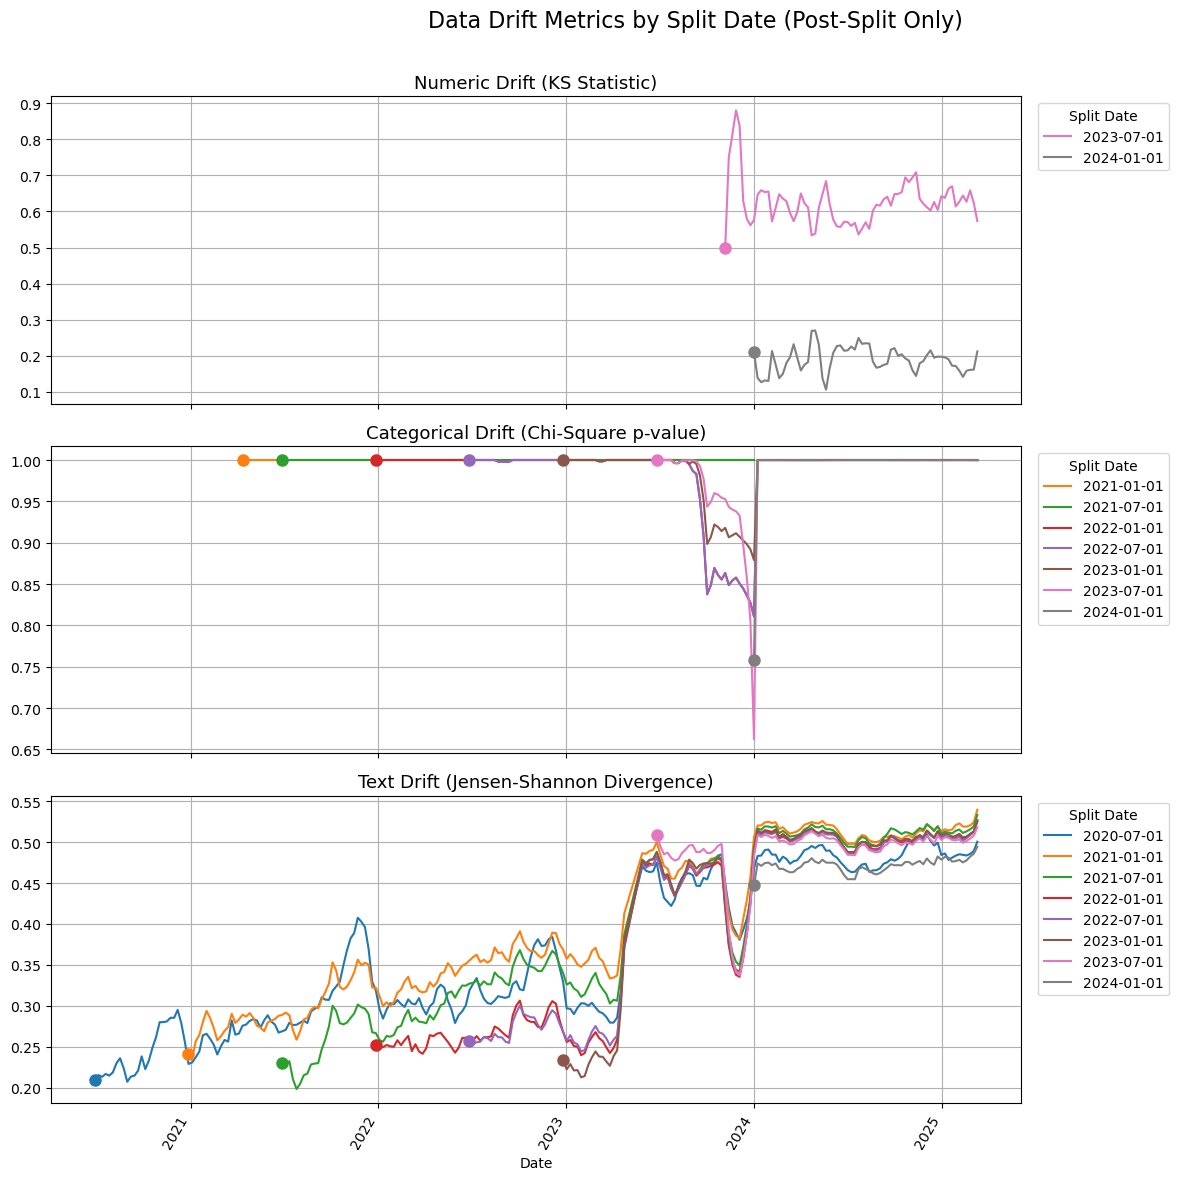

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Load results
df = pd.read_csv("results/data_drift_summary.csv")
df['start_week'] = pd.to_datetime(df['start_week'])

# Remove last 2 split dates
excluded = ["2024-07-01", "2025-01-01"]
df = df[~df['split_date'].isin(excluded)]

# Define metrics and subplot titles
metrics = {
    'avg_numeric_ks': 'Numeric Drift (KS Statistic)',
    'avg_categorical_chi2p': 'Categorical Drift (Chi-Square p-value)',
    'text_js_divergence': 'Text Drift (Jensen-Shannon Divergence)'
}

# Create color map (consistent across subplots)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = itertools.cycle(colors)
split_dates = sorted(df['split_date'].unique())
split_color_map = {split: next(color_cycle) for split in split_dates}

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for i, (col, title) in enumerate(metrics.items()):
    ax = axes[i]
    for split in split_dates:
        subset = df[(df['split_date'] == split) & (df[col].notna())]
        if subset.empty:
            continue
        color = split_color_map[split]
        ax.plot(subset['start_week'], subset[col], label=split, color=color)
        ax.plot(subset['start_week'].iloc[0], subset[col].iloc[0], 'o', markersize=8, color=color)

    ax.set_title(title, fontsize=13)
    ax.grid(True)
    if i == 2:
        ax.set_xlabel("Date")
    ax.legend(title="Split Date", bbox_to_anchor=(1.01, 1), loc='upper left')

plt.xticks(rotation=60, ha='right')
plt.suptitle("Data Drift Metrics by Split Date (Post-Split Only)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.97])
plt.show()

# variable define on the training data? 
# check cate features, each of them the missingness, should have been defined in the training data

In [10]:
import pandas as pd

# Load your drift summary file
df = pd.read_csv("results/data_drift_summary.csv")

# Optional: show all columns
pd.set_option("display.max_columns", None)

# Metrics to validate
metrics = ['avg_numeric_ks', 'avg_categorical_chi2p', 'text_js_divergence']

print("\n🔍 Non-NaN counts per split_date and metric:\n")
for metric in metrics:
    counts = df.groupby('split_date')[metric].apply(lambda x: x.notna().sum())
    print(f"\n{metric}:")
    print(counts)

# Highlight split_dates with fully missing numeric/categorical
print("\n❌ Split dates with completely missing drift metrics:")
for metric in ['avg_numeric_ks', 'avg_categorical_chi2p']:
    missing = df.groupby('split_date')[metric].apply(lambda x: x.notna().sum() == 0)
    if missing.any():
        print(f"\n{metric} missing for:")
        print(missing[missing].index.tolist())

# Optional: export for review
df[['split_date', 'start_week'] + metrics].to_csv("results/drift_debug_overview.csv", index=False)
print("\n✅ Summary saved to results/drift_debug_overview.csv")


🔍 Non-NaN counts per split_date and metric:


avg_numeric_ks:
split_date
2020-07-01     0
2021-01-01     0
2021-07-01     0
2022-01-01     0
2022-07-01     0
2023-01-01     0
2023-07-01    71
2024-01-01    63
2024-07-01    37
2025-01-01    11
Name: avg_numeric_ks, dtype: int64

avg_categorical_chi2p:
split_date
2020-07-01      0
2021-01-01     57
2021-07-01    128
2022-01-01    164
2022-07-01    138
2023-01-01    112
2023-07-01     90
2024-01-01     63
2024-07-01     37
2025-01-01     11
Name: avg_categorical_chi2p, dtype: int64

text_js_divergence:
split_date
2020-07-01    242
2021-01-01    216
2021-07-01    190
2022-01-01    164
2022-07-01    138
2023-01-01    112
2023-07-01     90
2024-01-01     63
2024-07-01     37
2025-01-01     11
Name: text_js_divergence, dtype: int64

❌ Split dates with completely missing drift metrics:

avg_numeric_ks missing for:
['2020-07-01', '2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01', '2023-01-01']

avg_categorical_chi2p missing for:
['2020-07

### ⚠️ Note on Missing Drift Lines for Early Split Dates

Several early split dates (from **2020–2023**) are missing in the **numeric** and **categorical** drift plots due to data incompleteness in the baseline period:

- **Numeric Drift (`avg_numeric_ks`)**:  
  The baseline data for earlier splits contained **no valid values** for the selected numeric feature `Priority_Score__c`.  
  As a result, the Kolmogorov–Smirnov test could not be computed for those splits.

- **Categorical Drift (`avg_categorical_chi2p`)**:  
  While categorical features were partially available (~25–45% non-missing),  
  the Chi-square drift could not be computed for some splits, likely due to insufficient category overlap between baseline and current windows.

- **Text Drift (`text_js_divergence`)**:  
  Text fields were consistently well-populated across all splits (>98% valid),  
  so text drift was successfully computed for all split dates.

**Implication**:  
Only recent split dates (e.g., from **2023–2025**) have sufficiently complete baseline data  
to support numeric and categorical drift analysis. This limitation is inherent in the data and not a technical error in the drift detection pipeline.


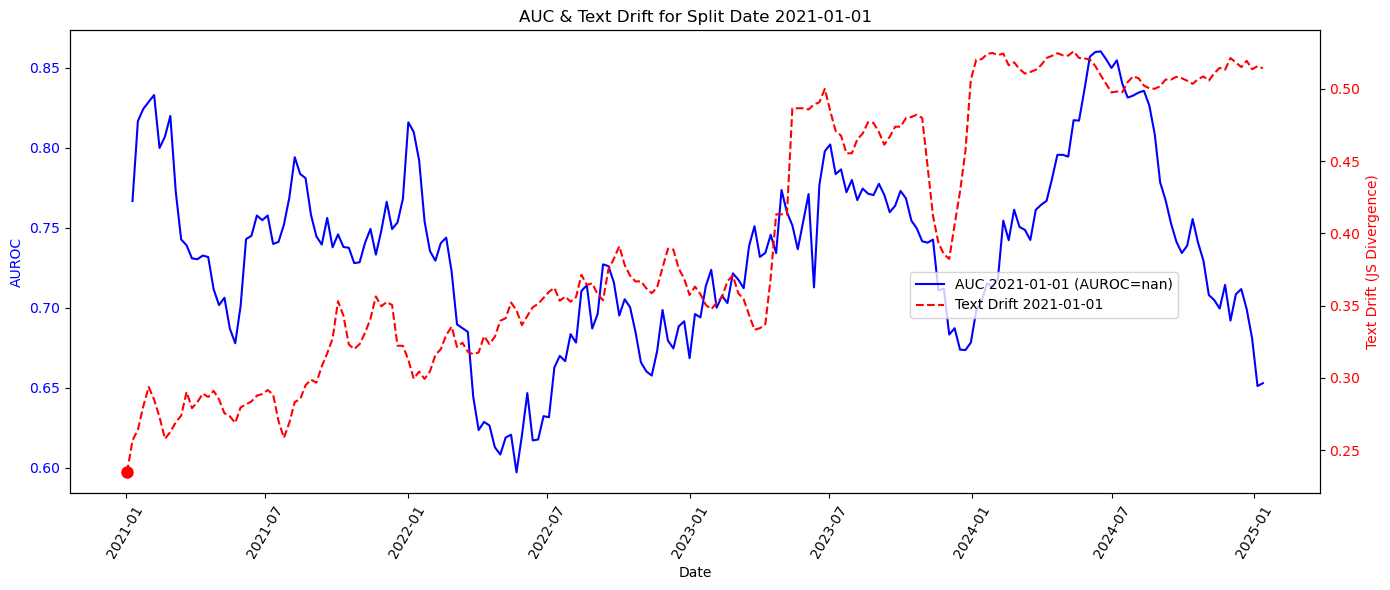

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load AUROC and Drift data
auroc_df = pd.read_csv("results/motality_auc_curves_results.csv")
drift_df = pd.read_csv("results/data_drift_summary.csv")


# Parse dates
auroc_df['date'] = pd.to_datetime(auroc_df['admitdatetime'])
drift_df['start_week'] = pd.to_datetime(drift_df['start_week'])

# Select split date
split_date = "2021-01-01"
auroc_split = auroc_df[auroc_df['split_date'] == split_date].copy()
drift_split = drift_df[drift_df['split_date'] == split_date].copy()

# Merge on nearest date (rounded to same granularity if needed)
merged = pd.merge_asof(
    auroc_split.sort_values("date"),
    drift_split.sort_values("start_week"),
    left_on="date",
    right_on="start_week",
    direction="nearest"
)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: AUROC
ax1.plot(merged['date'], merged['auroc'], color='blue', label=f"AUC {split_date} (AUROC={merged['auroc'].iloc[0]:.3f})")
ax1.plot(merged['date'].iloc[0], merged['auroc'].iloc[0], 'o', color='blue', markersize=8)
ax1.set_ylabel("AUROC", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right axis: Text Drift
ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['text_js_divergence'], '--', color='red', label=f"Text Drift {split_date}")
ax2.plot(merged['date'].iloc[0], merged['text_js_divergence'].iloc[0], 'o', color='red', markersize=8)
ax2.set_ylabel("Text Drift (JS Divergence)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Final touches
ax1.set_title(f"AUC & Text Drift for Split Date {split_date}")
ax1.set_xlabel("Date")
ax1.tick_params(axis='x', rotation=60)
fig.legend(loc="center right", bbox_to_anchor=(0.85, 0.5))
plt.tight_layout()
plt.show()

# Feature drift- PCA

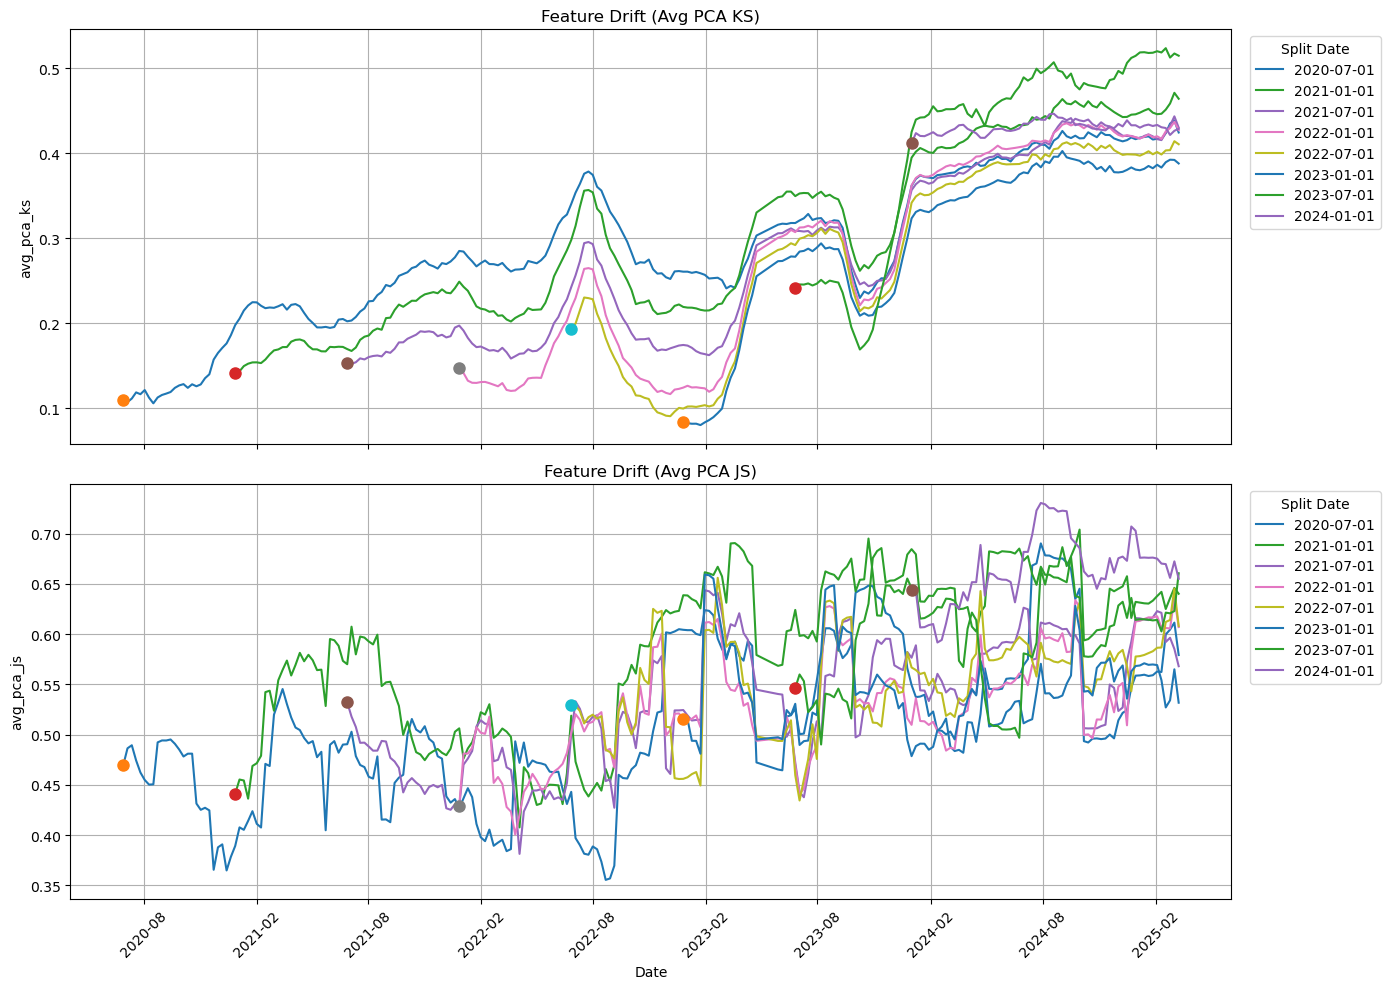

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# Load results
df = pd.read_csv("results/feature_drift_summary.csv")
df['start_week'] = pd.to_datetime(df['start_week'])

# Drop the last split date (optional)
split_dates = sorted(df['split_date'].unique())[:-1]

# Set up plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
metrics = {
    'avg_pca_ks': 'Feature Drift (Avg PCA KS)',
    'avg_pca_js': 'Feature Drift (Avg PCA JS)'
}

for i, (col, title) in enumerate(metrics.items()):
    ax = axes[i]
    for split in split_dates:
        subset = df[df['split_date'] == split]
        ax.plot(subset['start_week'], subset[col], label=split)
        if not subset.empty:
            ax.plot(subset['start_week'].iloc[0], subset[col].iloc[0], 'o', markersize=8)
    
    ax.set_title(title)
    ax.set_ylabel(col)
    ax.legend(title="Split Date", bbox_to_anchor=(1.01, 1), loc='upper left')
    ax.grid(True)

    # Apply 6-month x-axis locator
    ax.xaxis.set_major_locator(MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

axes[-1].set_xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# review code check variable missingness, across times
# PCA apply tfidf? when inclurding 36 QAs - 

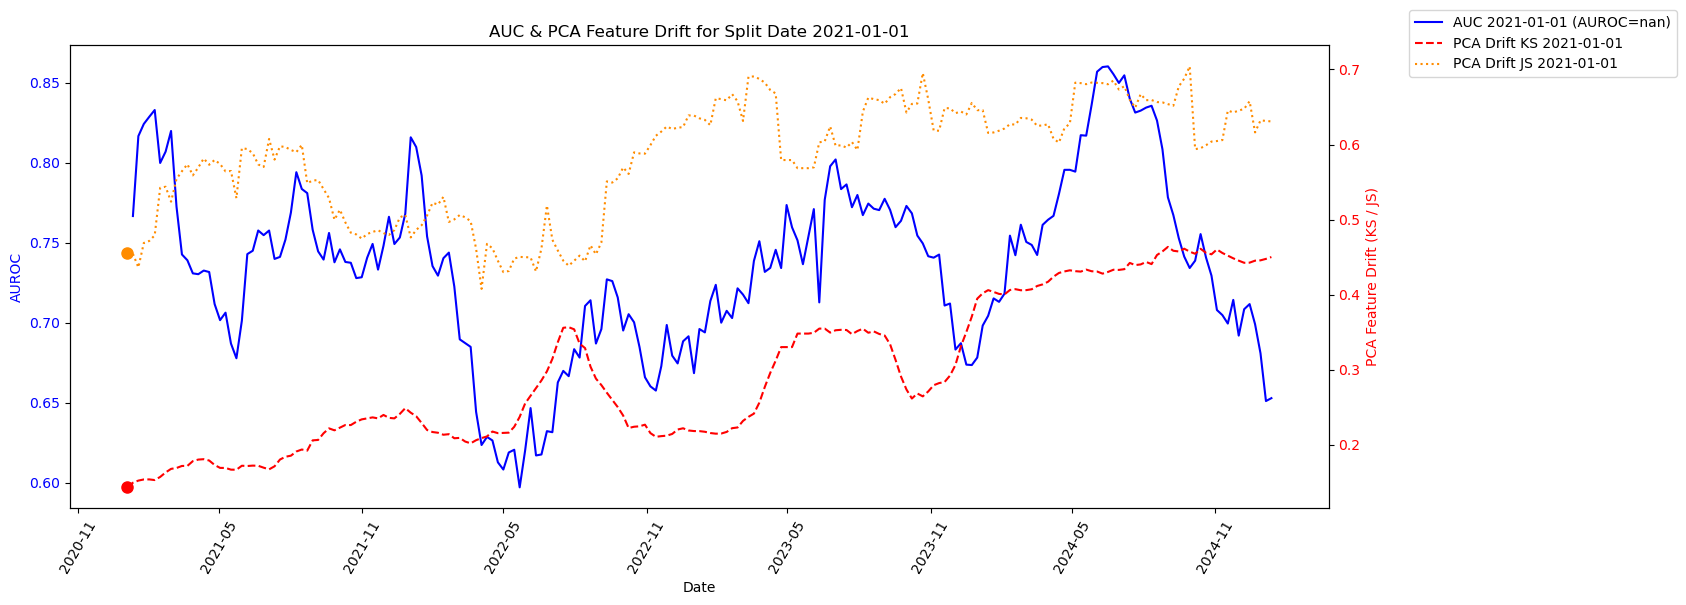

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# Load AUROC and PCA-based feature drift
auroc_df = pd.read_csv("results/motality_auc_curves_results.csv")
drift_df = pd.read_csv("results/feature_drift_summary.csv")

# Parse dates
auroc_df['date'] = pd.to_datetime(auroc_df['admitdatetime'])
drift_df['start_week'] = pd.to_datetime(drift_df['start_week'])

# Select split date
split_date = "2021-01-01"
auroc_split = auroc_df[auroc_df['split_date'] == split_date].copy()
drift_split = drift_df[drift_df['split_date'] == split_date].copy()

# Merge on nearest date
merged = pd.merge_asof(
    auroc_split.sort_values("date"),
    drift_split.sort_values("start_week"),
    left_on="date",
    right_on="start_week",
    direction="nearest"
)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: AUROC
ax1.plot(merged['date'], merged['auroc'], color='blue', label=f"AUC {split_date} (AUROC={merged['auroc'].iloc[0]:.3f})")
ax1.plot(merged['date'].iloc[0], merged['auroc'].iloc[0], 'o', color='blue', markersize=8)
ax1.set_ylabel("AUROC", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right axis: PCA Drift
ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['avg_pca_ks'], '--', color='red', label=f"PCA Drift KS {split_date}")
ax2.plot(merged['date'], merged['avg_pca_js'], ':', color='darkorange', label=f"PCA Drift JS {split_date}")
ax2.plot(merged['date'].iloc[0], merged['avg_pca_ks'].iloc[0], 'o', color='red', markersize=8)
ax2.plot(merged['date'].iloc[0], merged['avg_pca_js'].iloc[0], 'o', color='darkorange', markersize=8)
ax2.set_ylabel("PCA Feature Drift (KS / JS)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# X-axis formatting
ax1.set_title(f"AUC & PCA Feature Drift for Split Date {split_date}")
ax1.set_xlabel("Date")
ax1.tick_params(axis='x', rotation=60)
ax1.xaxis.set_major_locator(MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Move legend to the right outside
fig.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0), borderaxespad=0.)
plt.tight_layout()
plt.show()





# Predictive Model Distribution drift

## Metrics (what they mean)
- **JS (Label drift)** — change in **class mix** vs. baseline.  
  Range: 0–1 (0 = same mix). **Attention ≥ 0.20**.
- **KS (Score drift)** — **largest CDF gap** between baseline and current **scores**.  
  Range: 0–1. **Attention ≥ 0.20**.
- **PSI (Score drift, aggregated)** — sums many **bin-wise** score shifts (baseline-only bins, Laplace-smoothed).  
  Rules of thumb: <0.10 low, 0.10–0.25 moderate, **≥0.25 material** (investigate).

> **Why care?**  
> JS ↑ → prevalence change; can move AUPRC & PPV/NPV.  
> KS ↑ → strong local shape change; can affect ranking/thresholds.  
> PSI ↑ → widespread score re-shaping; often **calibration drift** or upstream data changes.

## How the plots were built
- Baseline = **first 12 weeks** per split. We plot **post-baseline** weeks only (first point is hollow dot).
- Weekly series with optional **4-week smoothing**.
- **Red dashed line** = attention threshold (JS/KS 0.20, PSI 0.25).
- **Moving-split only** (each line = a different split date).

---

## Today’s results — by task

### 30-Day Readmission
- **JS:** low (mix stable), slight rise late-2024.  
- **KS:** modest early; **rises late-2024/early-2025**, crosses 0.20.  
- **PSI:** **sustained ≥0.25** mid/late-2024 (material shift).  
**Read:** Strongest drift of the three → likely **calibration/feature shift**.  
**Act:** Check AUPRC drops; run Brier/ECE; audit pipeline changes late-2024; consider **recalibration / rolling retrain**; slice by service/admission source.

### Length of Stay (binary)
- **JS:** low; small end-of-year lift.  
- **KS:** ~0.1–0.2 with **late-2024 uptick** (some >0.20).  
- **PSI:** ~0.1–0.3, occasional spikes.  
**Read:** Milder **score-shape drift**; thresholds may drift.  
**Act:** Verify precision/recall at ops cutoff; light **recalibration**; check process/documentation changes.

### Mortality
- **JS:** near zero; small end-year lift.  
- **KS:** mostly ≤0.2; **shared late-2024 bump**.  
- **PSI:** high early spikes then **~0.15–0.30** with occasional peaks.  
**Read:** Relatively stable recently; shared end-year shift hints at **system-level change**.  
**Act:** Calibration check; cross-reference EHR/ETL changes; consider light recalibration.

---

## When it “needs attention”
- **Sustained** crossings of the red line (not one-week blips).  
- **Multiple metrics** or **multiple tasks** spike at the **same time** (system change likely).  
- **PSI ≥ 0.25** with low JS → probable **calibration drift** even if AUROC seems steady.

## Quick next steps
1. Line up drift dates with **AUROC/AUPRC** trajectories.  
2. Compute **Brier/ECE** (quarterly) + reliability curves.  
3. Drill down by **subgroup** (e.g., service line, admission source).  
4. Audit **pipeline/EHR** changes around late-2024.  
5. **Recalibrate** or **retrain on a rolling window**; adjust ops thresholds if needed.





[INFO] Recomputing trailing-6w drift for los …
[OK] Wrote results/los_distribution_drift_trailing6w.csv (rows=134)


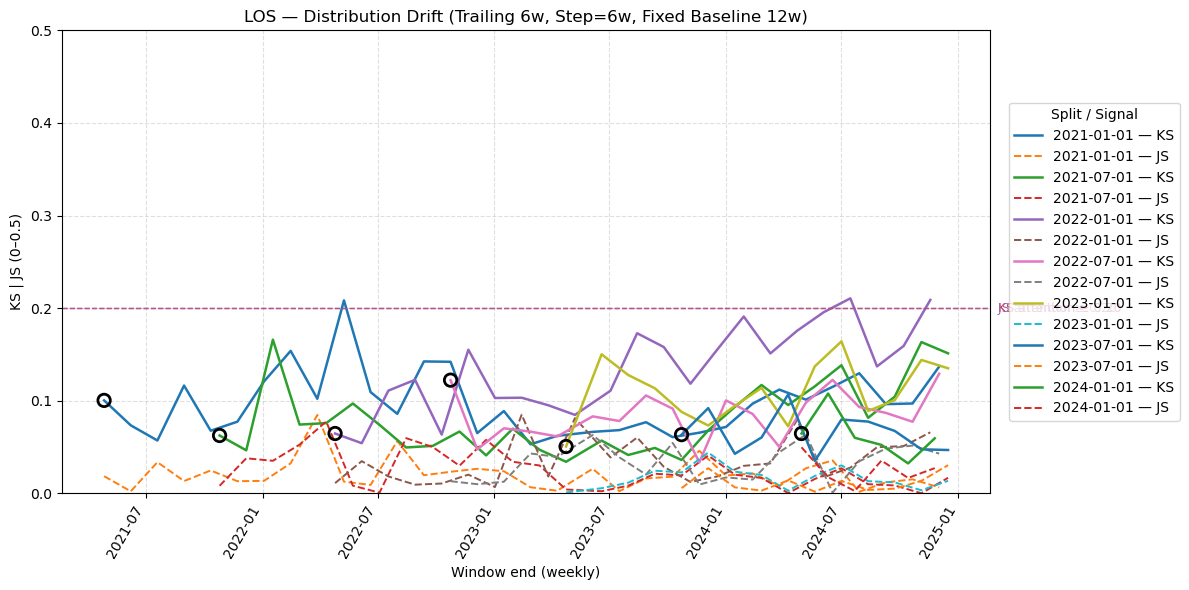

[OK] Saved results/plots/los_trailing6w_ks_js.png


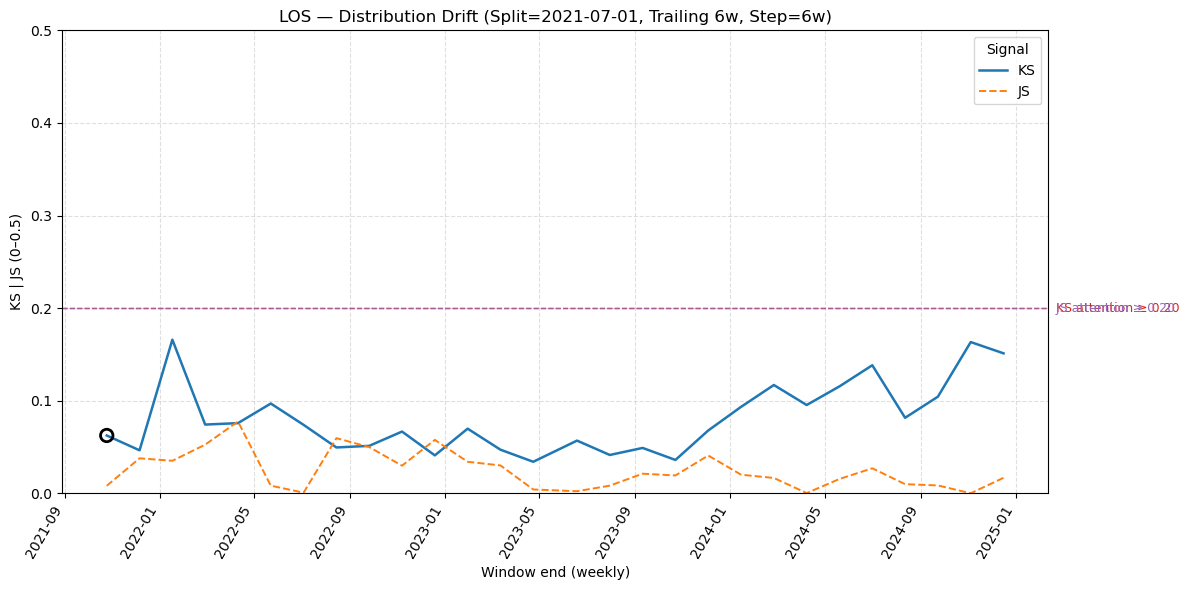

[OK] Saved results/plots/los_trailing6w_ks_js_split_2021-07-01.png


In [4]:
# JUPYTER — Recompute + Plot TRAILING-6W distribution drift (non-overlapping)
# - Only Mortality
# - Only KS (scores) + JS (labels)
# - Windows: 6 weeks, Step: 6 weeks (i.e., NO MOVING)
# - Baseline: first BASELINE_WEEKS weekly periods per split

# %matplotlib inline
import os, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import jensenshannon
from pandas.errors import EmptyDataError, ParserError

# =========================
# CONFIG
# =========================
RESULTS_DIR = "results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots"); os.makedirs(PLOTS_DIR, exist_ok=True)

TASK = "los"
#TASKS = ["mortality", "los", "readmit30"]

# Windowing aligned with PCA
TIME_FREQ     = "W"    # weekly periods
WINDOW_WEEKS  = 6      # trailing window length
STEP_WEEKS    = 6      # step size; =6 => non-overlapping (no moving). Use 1 for moving.
BASELINE_WEEKS = 12    # first N weekly periods form the (fixed) baseline
MIN_PERIOD_N   = 0     # keep 0 to include small weeks; set >0 to skip sparse windows
EPS            = 1e-9

# Plot style / thresholds
ATTN_JS = 0.20
ATTN_KS = 0.20

# =========================
# HELPERS
# =========================
def safe_read_csv(path, parse_dates=None, expected_cols=None):
    if not os.path.exists(path):
        print(f"[WARN] File not found: {path}")
        return pd.DataFrame(), False
    try:
        if os.path.getsize(path) == 0:
            print(f"[WARN] Zero-byte file: {path}")
            return pd.DataFrame(), False
    except OSError as e:
        print(f"[WARN] Could not stat file {path}: {e}")
        return pd.DataFrame(), False

    try:
        df = pd.read_csv(path, parse_dates=parse_dates)
    except (EmptyDataError, ParserError) as e:
        print(f"[WARN] Read error on {path}: {e}")
        return pd.DataFrame(), False
    except UnicodeDecodeError:
        with open(path, "rb") as f:
            raw = f.read()
        try:
            df = pd.read_csv(io.StringIO(raw.decode("utf-8", errors="ignore")), parse_dates=parse_dates)
        except Exception as e:
            print(f"[WARN] Fallback read failed for {path}: {e}")
            return pd.DataFrame(), False

    if expected_cols and not set(expected_cols).issubset(df.columns):
        print(f"[WARN] {path} missing columns: {set(expected_cols)-set(df.columns)}")
    return df, True

def atomic_write_csv(df, path):
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False)
    os.replace(tmp, path)

def add_period_weekly(df, date_col="admitdatetime", freq="W"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["period"] = df[date_col].dt.to_period(freq).dt.start_time
    return df

# =========================
# CORE: trailing 6w drift
# =========================
def compute_drift_trailing(
    scored,
    date_col="admitdatetime",
    label_col="y_true",
    score_col="y_pred",
    split_col="split_date",
    baseline_periods=12,
    window_weeks=6,
    step_weeks=6,
    time_freq="W",
    min_period_n=0,
    eps=1e-9,
):
    out = []
    df = add_period_weekly(scored, date_col, time_freq)

    for split in sorted(df[split_col].astype(str).unique()):
        d = df[df[split_col].astype(str) == str(split)].sort_values("period")
        periods = pd.Index(d["period"].dropna().unique())
        if len(periods) < baseline_periods + window_weeks:
            print(f"[INFO] Split {split}: not enough periods ({len(periods)}). Need ≥ {baseline_periods+window_weeks}.")
            continue

        # Fixed baseline = first N periods
        base_mask = d["period"].isin(periods[:baseline_periods])
        base_y = d.loc[base_mask, label_col].astype(int).values
        base_s = d.loc[base_mask, score_col].astype(float).values
        if base_s.size == 0:
            print(f"[INFO] Split {split}: empty baseline scores.")
            continue

        base_pos = (base_y == 1).mean() if base_y.size else np.nan
        base_label_vec = np.array([1 - base_pos, base_pos], dtype=float)

        # Window ends: start AFTER baseline, ensure full 6w available
        end_idx_start = baseline_periods + window_weeks - 1
        end_indices = list(range(end_idx_start, len(periods), step_weeks))

        for ei in end_indices:
            window_ends_at = periods[ei]
            # build trailing window [ei-window_weeks+1, ei]
            w_start = periods[ei - window_weeks + 1]
            mask = (d["period"] >= w_start) & (d["period"] <= window_ends_at)
            g = d[mask]
            if g.empty:
                continue
            if min_period_n and len(g) < min_period_n:
                continue

            cur_y = g[label_col].astype(int).values
            cur_s = g[score_col].astype(float).values
            if cur_y.size == 0 or cur_s.size == 0:
                continue

            # JS on labels (prevalence vectors)
            cur_pos = (cur_y == 1).mean()
            cur_label_vec = np.array([1 - cur_pos, cur_pos], dtype=float)
            js_labels = jensenshannon(
                np.clip(base_label_vec, eps, 1),
                np.clip(cur_label_vec,  eps, 1)
            )

            # KS on scores (entire distributions)
            ks_score = stats.ks_2samp(base_s, cur_s, alternative="two-sided", mode="auto")[0]

            out.append({
                "split_date": str(split),
                "window_end": pd.to_datetime(window_ends_at),
                "window_start": pd.to_datetime(w_start),
                "window_weeks": int(window_weeks),
                "n_window": int(len(g)),
                "label_pos_rate": float(cur_pos),
                "drift_label_JS": float(js_labels),
                "drift_score_KS": float(ks_score),
            })

    cols = ["split_date","window_start","window_end","window_weeks","n_window","label_pos_rate",
            "drift_label_JS","drift_score_KS"]
    return pd.DataFrame(out, columns=cols)

# =========================
# RUN: recompute + save
# =========================
scored_path = os.path.join(RESULTS_DIR, f"{TASK}_scored_predictions.csv")
drift_path  = os.path.join(RESULTS_DIR, f"{TASK}_distribution_drift_trailing6w.csv")

s, ok = safe_read_csv(scored_path, parse_dates=["admitdatetime"],
                      expected_cols=["split_date","admitdatetime","y_true","y_pred"])
if not ok or s.empty:
    raise SystemExit(f"[ERROR] Cannot read {scored_path}")

print(f"[INFO] Recomputing trailing-6w drift for {TASK} …")
drift = compute_drift_trailing(
    s,
    date_col="admitdatetime",
    label_col="y_true",
    score_col="y_pred",
    split_col="split_date",
    baseline_periods=BASELINE_WEEKS,
    window_weeks=WINDOW_WEEKS,
    step_weeks=STEP_WEEKS,     # =6 => NO MOVING; set =1 to make it moving if needed
    time_freq=TIME_FREQ,
    min_period_n=MIN_PERIOD_N,
    eps=EPS,
)

if drift is None or drift.empty:
    print("[WARN] Drift is empty. Writing header-only CSV.")
    drift = pd.DataFrame(columns=["split_date","window_start","window_end","window_weeks","n_window",
                                  "label_pos_rate","drift_label_JS","drift_score_KS"])

atomic_write_csv(drift, drift_path)
print(f"[OK] Wrote {drift_path} (rows={len(drift)})")

# =========================
# PLOT: KS & JS together (all splits)
# =========================
if not drift.empty:
    plt.figure(figsize=(12,6))
    for sd, g in drift.groupby("split_date"):
        g = g.sort_values("window_end")
        # Solid = KS (scores), Dashed = JS (labels)
        plt.plot(g["window_end"], g["drift_score_KS"], label=f"{sd} — KS", lw=1.8)
        plt.plot(g["window_end"], g["drift_label_JS"], linestyle="--", label=f"{sd} — JS", lw=1.4)

        # mark first window point
        fp = g.iloc[0]
        plt.scatter(fp["window_end"], fp["drift_score_KS"], s=80, facecolors="none",
                    edgecolors="black", linewidths=2, zorder=5)

    # thresholds
    ax = plt.gca()
    plt.axhline(ATTN_KS, color="tab:red", ls="--", lw=1.0, alpha=0.9)
    plt.text(ax.get_xlim()[1], ATTN_KS, f"  KS attention ≥ {ATTN_KS:.2f}",
             va="center", ha="left", fontsize=9, color="tab:red")

    plt.axhline(ATTN_JS, color="tab:purple", ls="--", lw=1.0, alpha=0.7)
    plt.text(ax.get_xlim()[1], ATTN_JS, f"  JS attention ≥ {ATTN_JS:.2f}",
             va="center", ha="left", fontsize=9, color="tab:purple")

    # scale to 0–0.5
    plt.ylim(0, 0.5)

    plt.title(f"LOS — Distribution Drift (Trailing {WINDOW_WEEKS}w, Step={STEP_WEEKS}w, Fixed Baseline {BASELINE_WEEKS}w)")
    plt.xlabel("Window end (weekly)")
    plt.ylabel("KS | JS (0–0.5)")
    plt.xticks(rotation=60, ha="right")
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend(title="Split / Signal", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.)
    plt.tight_layout()

    out_png = os.path.join(PLOTS_DIR, f"{TASK}_trailing6w_ks_js.png")
    plt.savefig(out_png, dpi=200)
    plt.show()
    print(f"[OK] Saved {out_png}")


# =========================
# PLOT: Only split 2027-07-01
# =========================
if not drift.empty:
    sd_target = "2021-07-01"   # adjust if your split_date is stored differently
    g = drift[drift["split_date"] == sd_target].sort_values("window_end")
    if not g.empty:
        plt.figure(figsize=(12,6))
        plt.plot(g["window_end"], g["drift_score_KS"], label="KS", lw=1.8)
        plt.plot(g["window_end"], g["drift_label_JS"], linestyle="--", label="JS", lw=1.4)

        # mark first window point
        fp = g.iloc[0]
        plt.scatter(fp["window_end"], fp["drift_score_KS"], s=80, facecolors="none",
                    edgecolors="black", linewidths=2, zorder=5)

        # thresholds
        ax = plt.gca()
        plt.axhline(ATTN_KS, color="tab:red", ls="--", lw=1.0, alpha=0.9)
        plt.text(ax.get_xlim()[1], ATTN_KS, f"  KS attention ≥ {ATTN_KS:.2f}",
                 va="center", ha="left", fontsize=9, color="tab:red")

        plt.axhline(ATTN_JS, color="tab:purple", ls="--", lw=1.0, alpha=0.7)
        plt.text(ax.get_xlim()[1], ATTN_JS, f"  JS attention ≥ {ATTN_JS:.2f}",
                 va="center", ha="left", fontsize=9, color="tab:purple")

        # scale to 0–0.5
        plt.ylim(0, 0.5)

        plt.title(f"LOS — Distribution Drift (Split={sd_target}, Trailing {WINDOW_WEEKS}w, Step={STEP_WEEKS}w)")
        plt.xlabel("Window end (weekly)")
        plt.ylabel("KS | JS (0–0.5)")
        plt.xticks(rotation=60, ha="right")
        plt.grid(True, ls="--", alpha=0.4)
        plt.legend(title="Signal")
        plt.tight_layout()

        out_png = os.path.join(PLOTS_DIR, f"{TASK}_trailing6w_ks_js_split_{sd_target}.png")
        plt.savefig(out_png, dpi=200)
        plt.show()
        print(f"[OK] Saved {out_png}")
    else:
        print(f"[WARN] No rows for split_date={sd_target}")



